# Real vs AI-generated image classifier

In [3]:
# All imports
import os
from collections import defaultdict
import cv2
import numpy as np
from tqdm import tqdm
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from scipy.fftpack import dct
from numpy.fft import fft2, fftshift
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from sklearn.calibration import CalibratedClassifierCV



#### Dataset

I'm extracting frames from the deepaction_v1 dataset[1] to use as input images for my image classifier.
It has 7 folders. Pexels contains real videos and the rest contain AI-generated videos from different models.
* BDAnimateDiffLightning: 500 videos
* CogVideoX5B: 500 videos
* Pexels: 100 videos
* RunwayML: 505 videos
* StableDiffusion: 500 videos
* Veo: 100 videos
* VideoPoet: 400 videos

[1]https://huggingface.co/datasets/faridlab/deepaction_v1
@misc{bohacek2024human,
      title={Human Action CLIPS: Detecting AI-generated Human Motion}, 
      author={Matyas Bohacek and Hany Farid},
      year={2024},
      eprint={2412.00526},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2412.00526}, 
}


#### Extracting frames from the videos.

Since there's a lot of ai-generated videos and not enough real videos, 
* For AI images: 4 frames per video are extracted
* For real images: 100 frames per video are extracted.

After frame extraction, we get
* 9999 real images
* 9920 ai-generated images

In [ ]:
print("Starting frame extraction process...")
# Defining input and output directories
real_dir = './deepaction_v1/Pexels'
ai_dirs = [
    './deepaction_v1/BDAnimateDiffLightning',
    './deepaction_v1/CogVideoX5B',
    './deepaction_v1/RunwayML',
    './deepaction_v1/StableDiffusion',
    './deepaction_v1/Veo',
    './deepaction_v1/VideoPoet'
]
output_real = 'frames/real'
output_ai = 'frames/aigenerated'
video_extensions = ('.mp4', '.avi', '.mov', '.mkv')

# Ensuring the output directories exist
os.makedirs(output_real, exist_ok=True)
os.makedirs(output_ai, exist_ok=True)

# Function to extract frames from videos
def extract_frames(video_path, save_dir, num_frames, start_index, output_basename):
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"[ERROR] Cannot open video: {video_path}")
        return 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print(f"[WARNING] No frames in video: {video_path}")
        cap.release()
        return 0

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    saved_count = 0

    for i, frame_idx in enumerate(indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret or frame is None:
            print(f"[WARNING] Could not read frame {frame_idx} in {video_path}")
            continue

        filename = f"{output_basename}{start_index + saved_count}.jpg"
        frame_path = os.path.join(save_dir, filename)
        cv2.imwrite(frame_path, frame)
        saved_count += 1

    cap.release()
    return saved_count

# Function to process real videos
def process_real_videos(real_dir, output_dir, video_extensions):
    print("Processing real videos from Pexels...")
    frame_index = 0
    for root, _, files in os.walk(real_dir):
        for file in files:
            if file.lower().endswith(video_extensions):
                video_path = os.path.join(root, file)
                print(f"Extracting from real video: {video_path}")
                count = extract_frames(
                    video_path,
                    save_dir=output_dir,
                    num_frames=100,
                    start_index=frame_index,
                    output_basename="real_"
                )
                frame_index += count
    print(f"Total real frames saved: {frame_index}")

# Function to process AI-Generated Videos
def process_ai_videos(ai_dirs, output_dir, video_extensions):
    print("Processing AI-generated videos...")
    frame_index = 0
    for ai_dir in ai_dirs:
        for root, _, files in os.walk(ai_dir):
            for file in files:
                if file.lower().endswith(video_extensions):
                    video_path = os.path.join(root, file)
                    print(f"Extracting from AI video: {video_path}")
                    count = extract_frames(
                        video_path,
                        save_dir=output_dir,
                        num_frames=4,
                        start_index=frame_index,
                        output_basename="ai_"
                    )
                    frame_index += count
    print(f"Total AI-generated frames saved: {frame_index}")

In [ ]:
# Executing the frame extraction
process_real_videos(real_dir, output_real, video_extensions)
print("Frame extraction completed.")

process_ai_videos(ai_dirs, output_ai, video_extensions)
print("Frame extraction completed.")

#### Preprocessing the input images
resizing the images to 512x512 if its not already that size

In [ ]:
# Input folders for raw images
input_dirs = {
    'real': 'frames/real',
    'ai': 'frames/aigenerated'
}
# Output root folder for processed images
output_root = 'processed_512x512'
os.makedirs(output_root, exist_ok=True)
# Target size for resizing
target_size = 512


# Function to resize with Padding while maintaining aspect ratio by padding to fit target size
def resize_with_padding(img, target_size=512):
    h, w = img.shape[:2]

    # Determining scale factor so the longest edge becomes target_size
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resizing using area interpolation
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Computing required padding
    top = (target_size - new_h) // 2
    bottom = target_size - new_h - top
    left = (target_size - new_w) // 2
    right = target_size - new_w - left

    # Applying padding using black (0,0,0) borders
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded

# Processing images in the input directories
for label, folder in input_dirs.items():
    input_path = folder
    output_path = os.path.join(output_root, label)
    os.makedirs(output_path, exist_ok=True)

    print(f"\n Processing '{label}' images...")

    for fname in tqdm(os.listdir(input_path), desc=f"Processing {label}"):
        if fname.lower().endswith(('.jpg')):
            in_file = os.path.join(input_path, fname)
            out_file = os.path.join(output_path, fname)

            img = cv2.imread(in_file)
            if img is None:
                print(f"[WARNING] Skipping unreadable image: {in_file}")
                continue

            h, w = img.shape[:2]

            # If image is already 512x512, no need to resize
            if h == target_size and w == target_size:
                cv2.imwrite(out_file, img)
            else:
                img_resized = resize_with_padding(img, target_size)
                cv2.imwrite(out_file, img_resized)

print("\n All images processed and saved in 'processed_512x512'")



📂 Processing 'real' images...


Processing real: 100%|██████████| 9999/9999 [07:42<00:00, 21.62it/s]



📂 Processing 'ai' images...


Processing ai: 100%|██████████| 9920/9920 [01:00<00:00, 162.89it/s]


✅ All images processed and saved in 'processed_512x512'


#### Train/Test/VALIDATE Split

The processed images are split into training, testing, and validation sets using a 70/15/15 split, and the results are stored in CSV files.
Label 1 is assigned if an image is AI-generated and Label 0 is assigned if an image is real.

In [ ]:
input_dirs = {
    'real': 'processed_512x512/real',
    'ai': 'processed_512x512/ai'
}
labels = {
    'real': 0,
    'ai': 1
}

all_data = []

for label_name, dir_path in input_dirs.items():
    label = labels[label_name]
    image_paths = glob.glob(os.path.join(dir_path, '*.jpg'))

    for path in image_paths:
        all_data.append((path, label))

# Converting to DataFrame
df = pd.DataFrame(all_data, columns=['filepath', 'label'])

# Shuffling and Splitting the dataset
train_val, test = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.1765, stratify=train_val['label'], random_state=42)
# 0.1765 * 0.85 ≈ 0.15 → ensures 70/15/15 split

# Saving to CSV
os.makedirs('splits', exist_ok=True)
train.to_csv('splits/train.csv', index=False)
val.to_csv('splits/val.csv', index=False)
test.to_csv('splits/test.csv', index=False)

# Printing a Summary
print(f"Total images: {len(df)}")
print(f"Train: {len(train)} | Val: {len(val)} | Test: {len(test)}")
print("\nCSV files saved to: splits/train.csv, val.csv, test.csv")


Total images: 19919
Train: 13942 | Val: 2989 | Test: 2988

CSV files saved to: splits/train.csv, val.csv, test.csv


#### Feature Extraction
I'm using a subset of my dataset to identify important features. For 1% of the images in the training set, I'm extracting various features to determine which ones are useful for my classifier. I'm visualizing the features for 10 of these images.

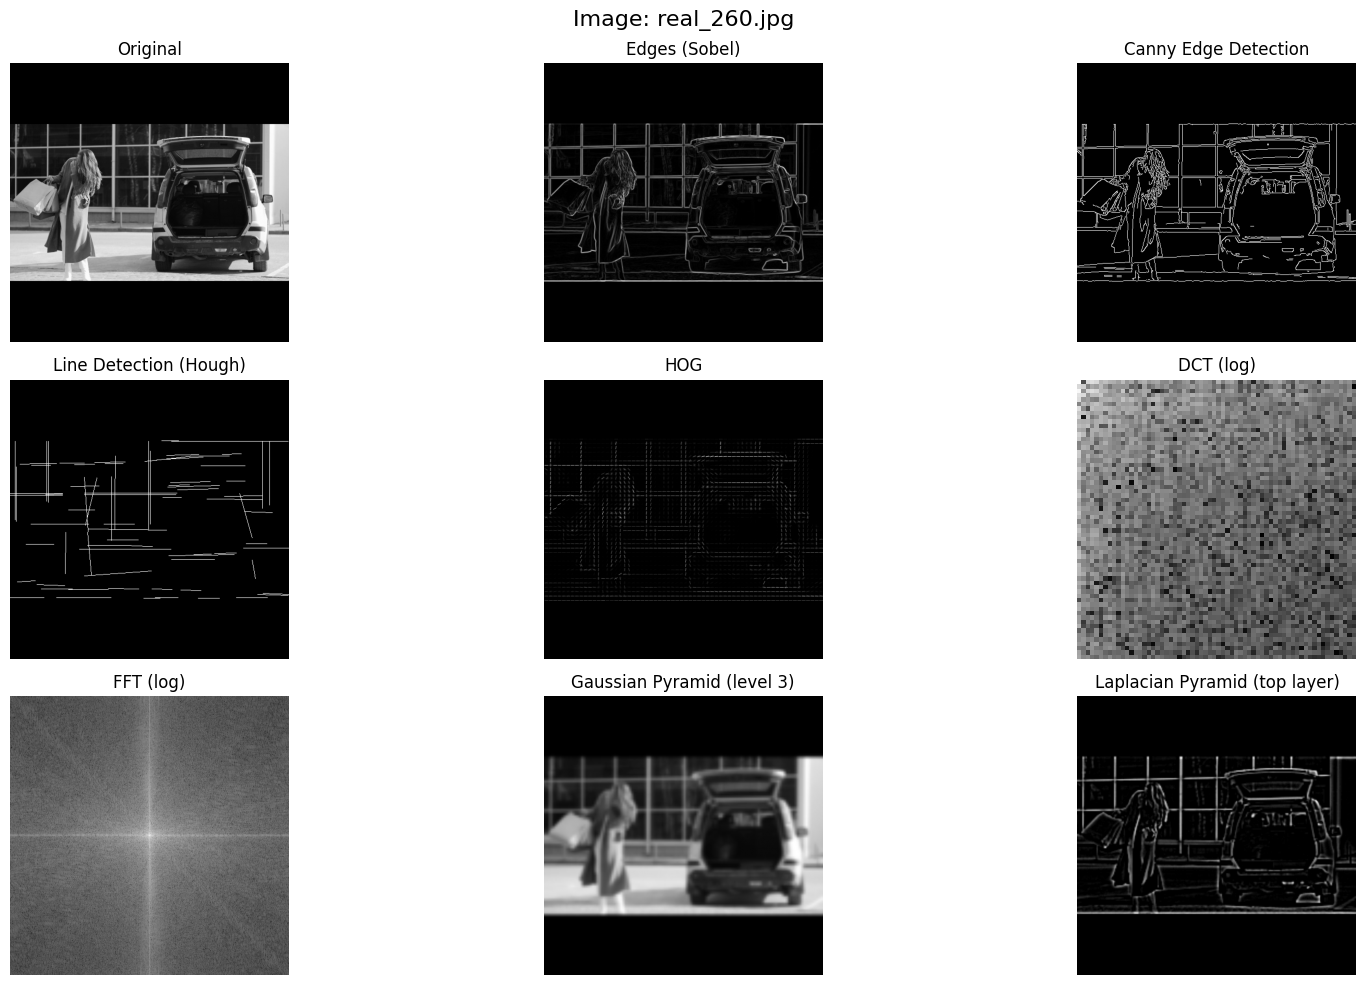

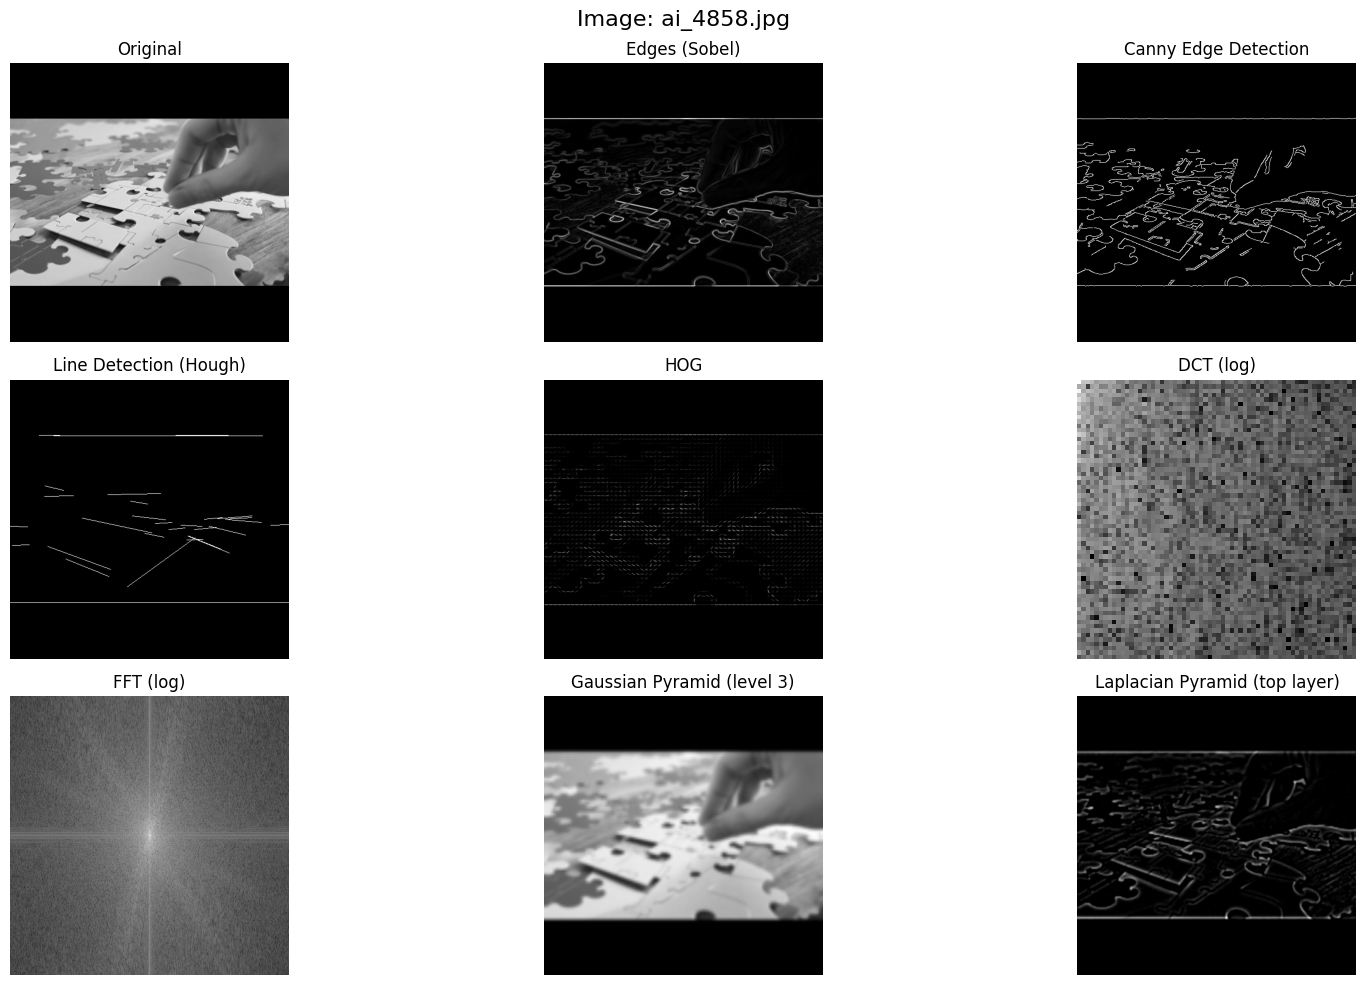

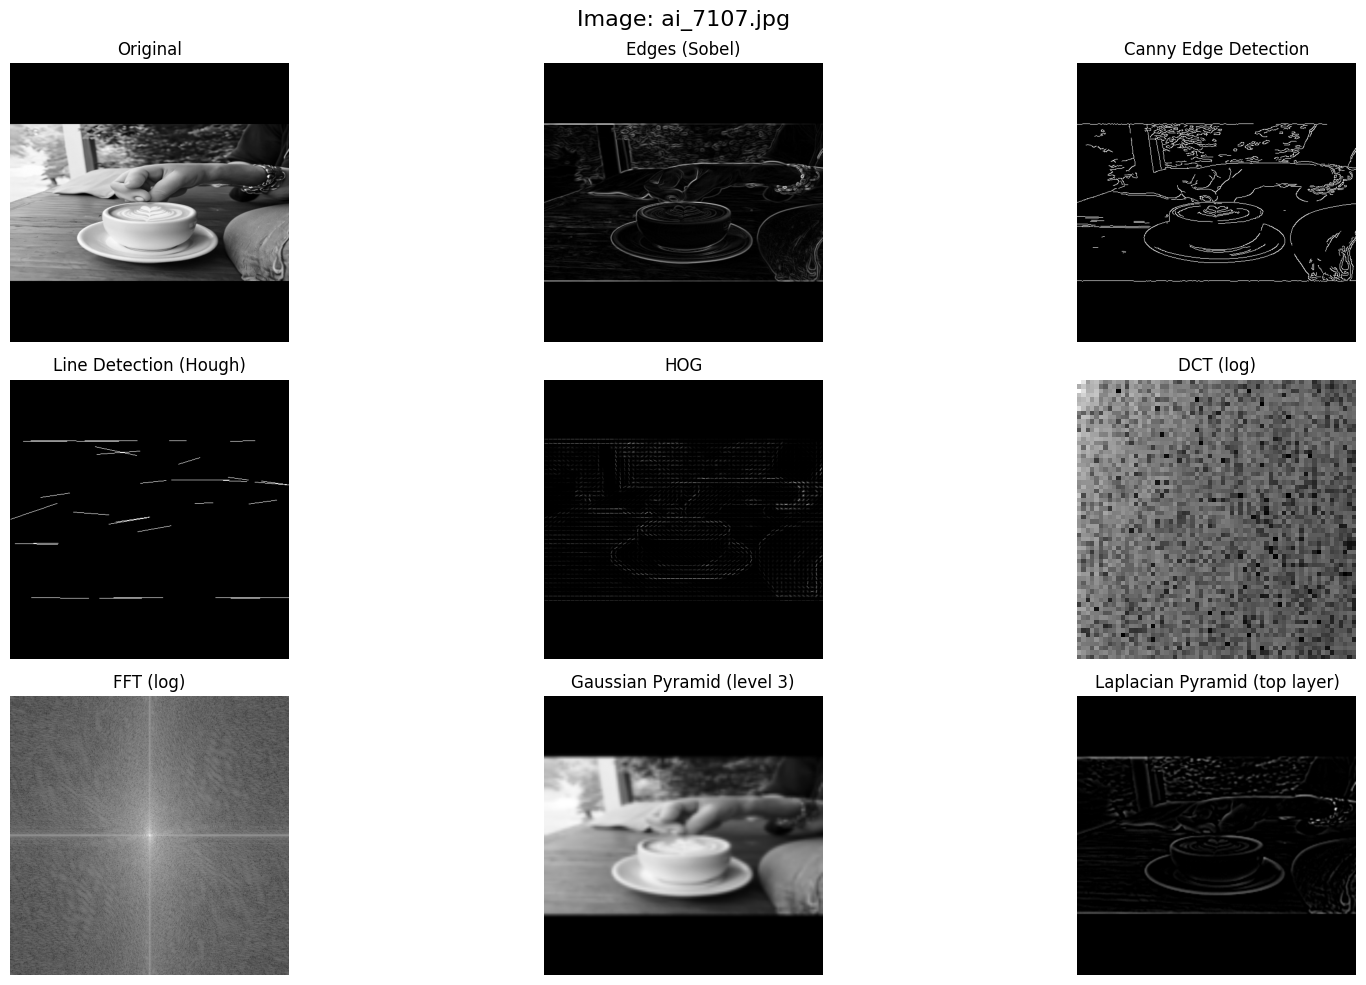

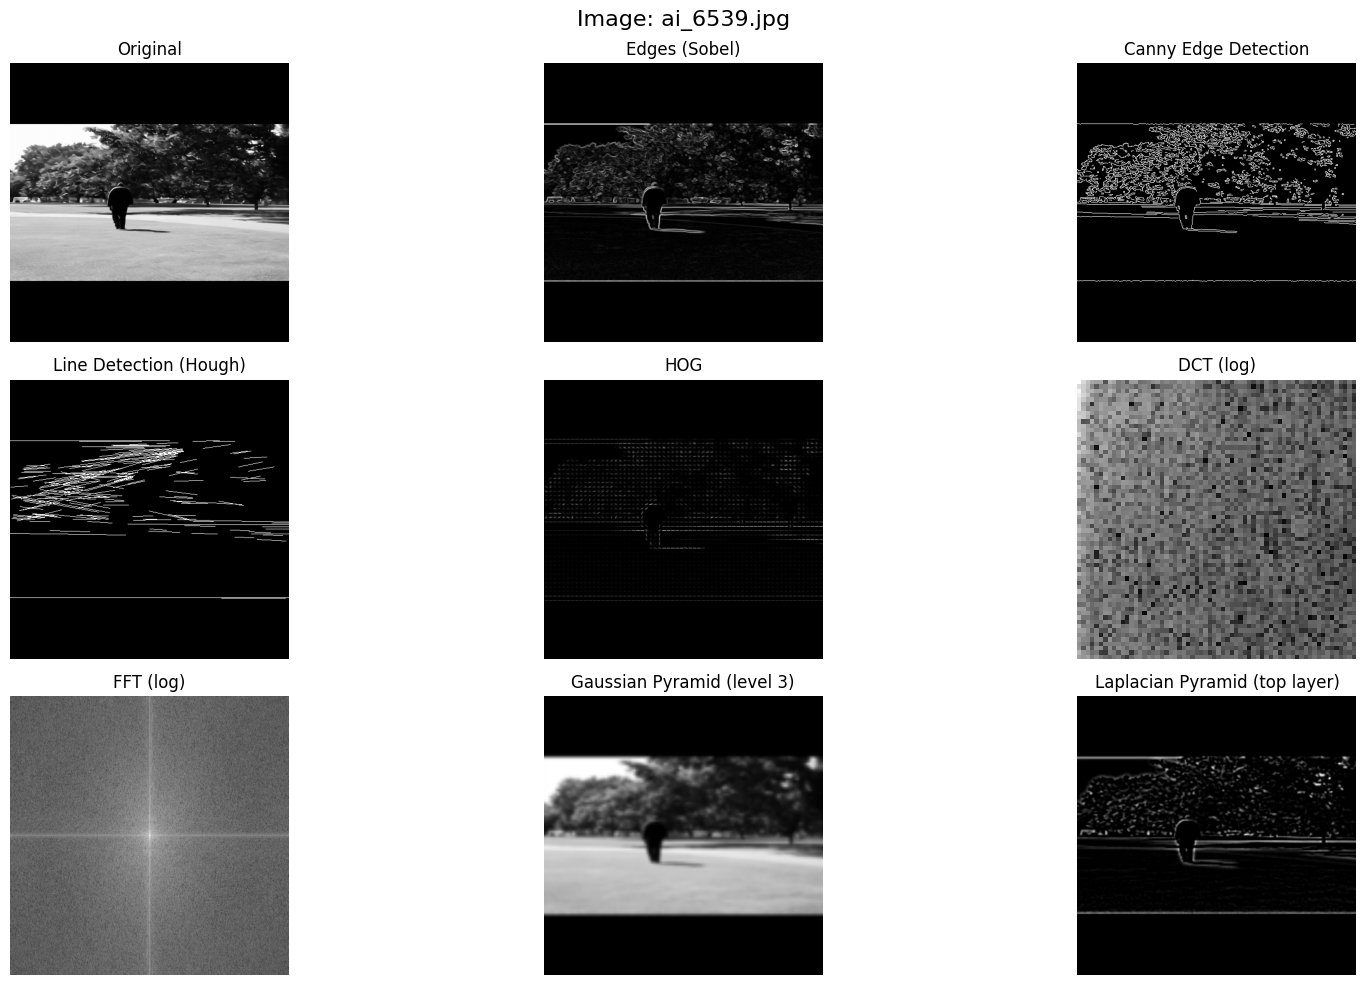

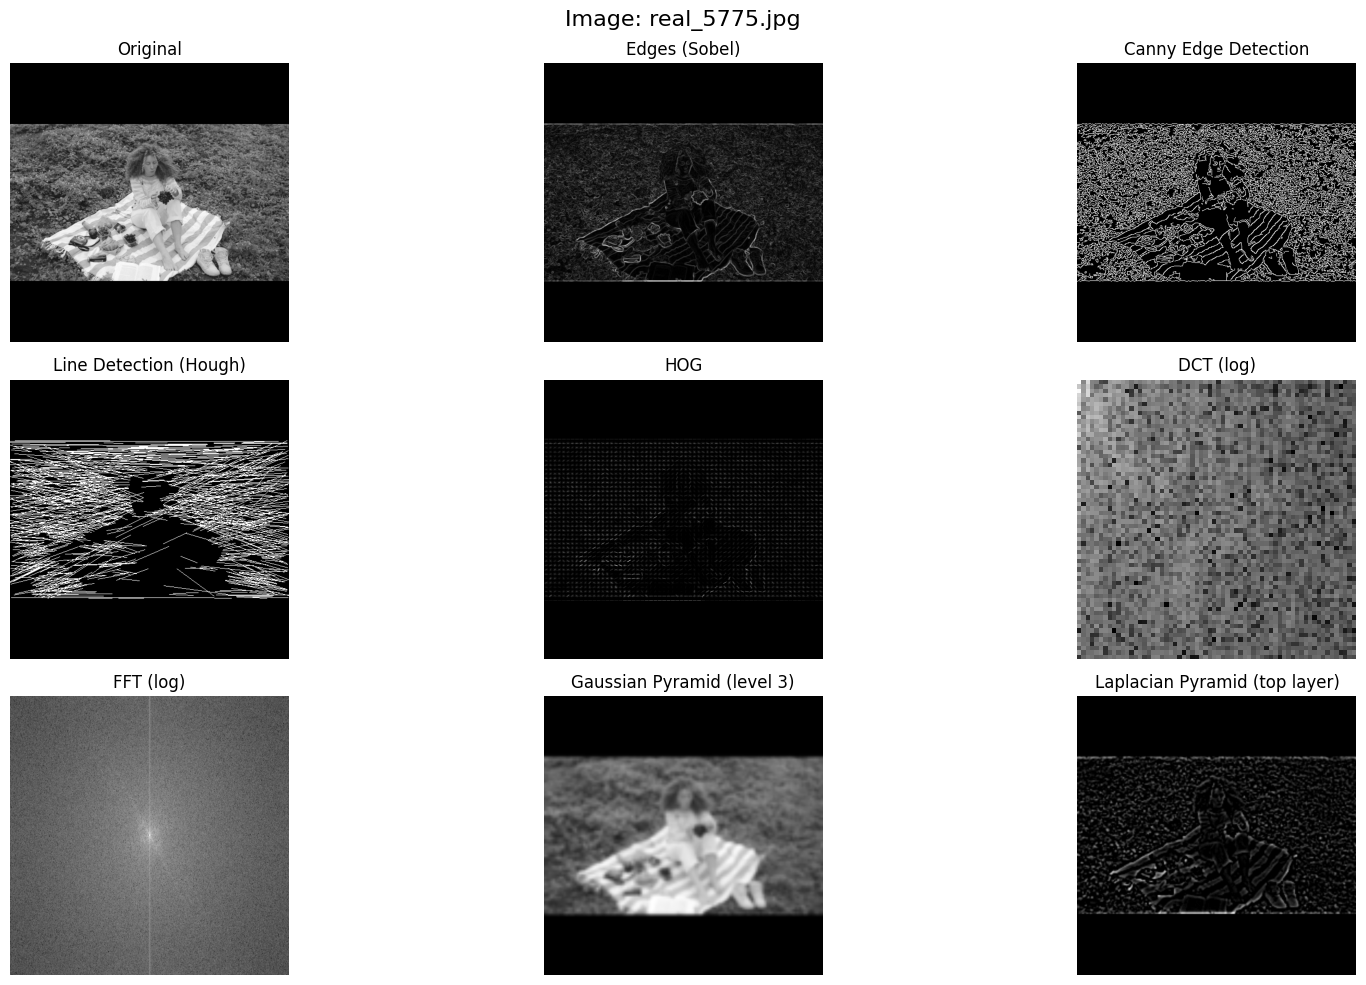

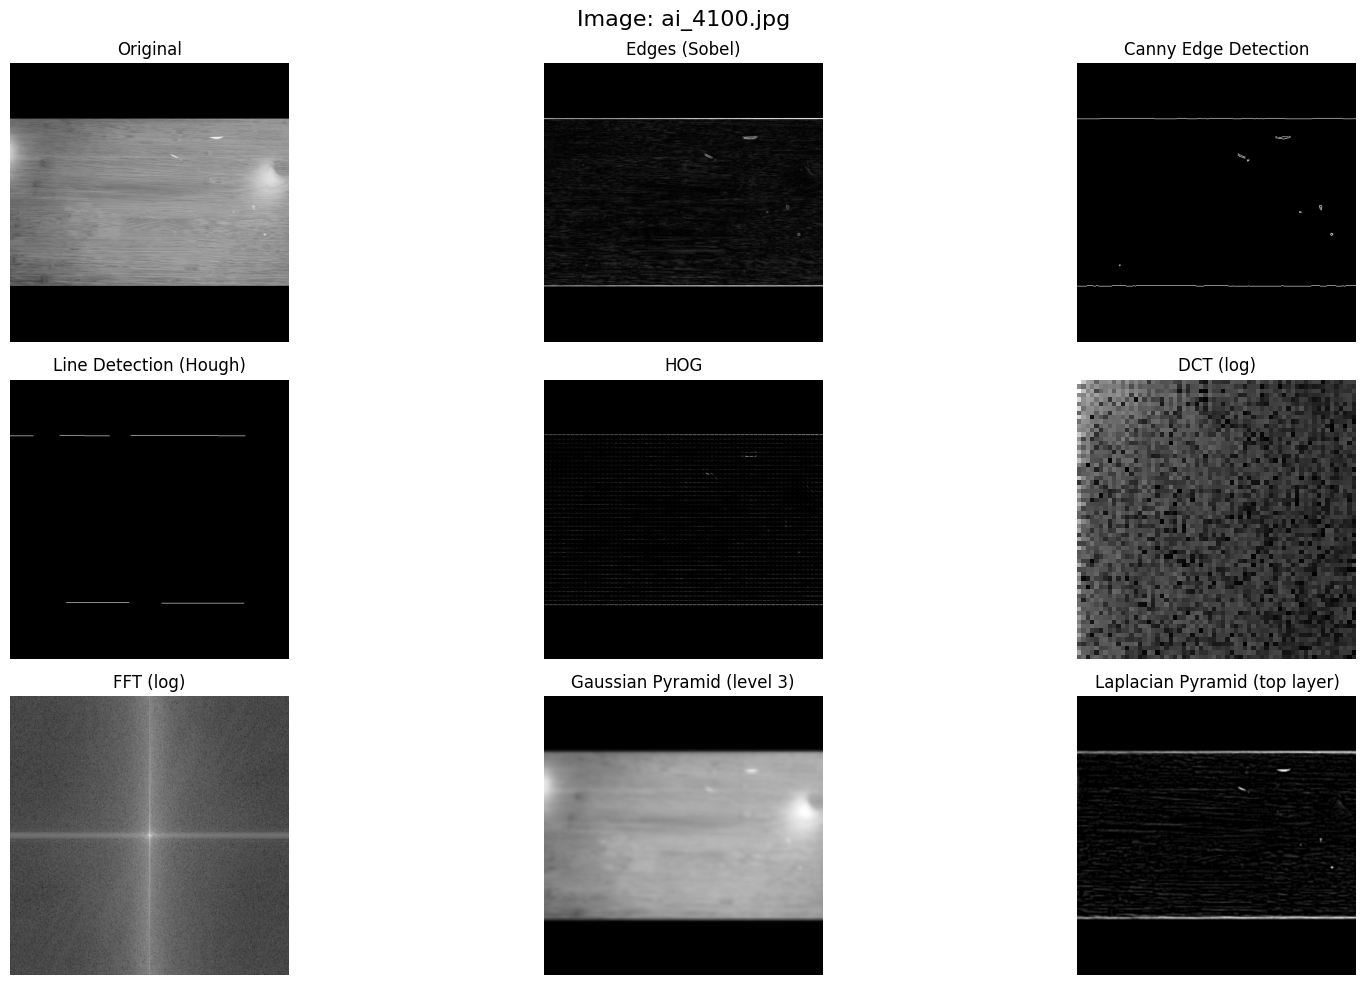

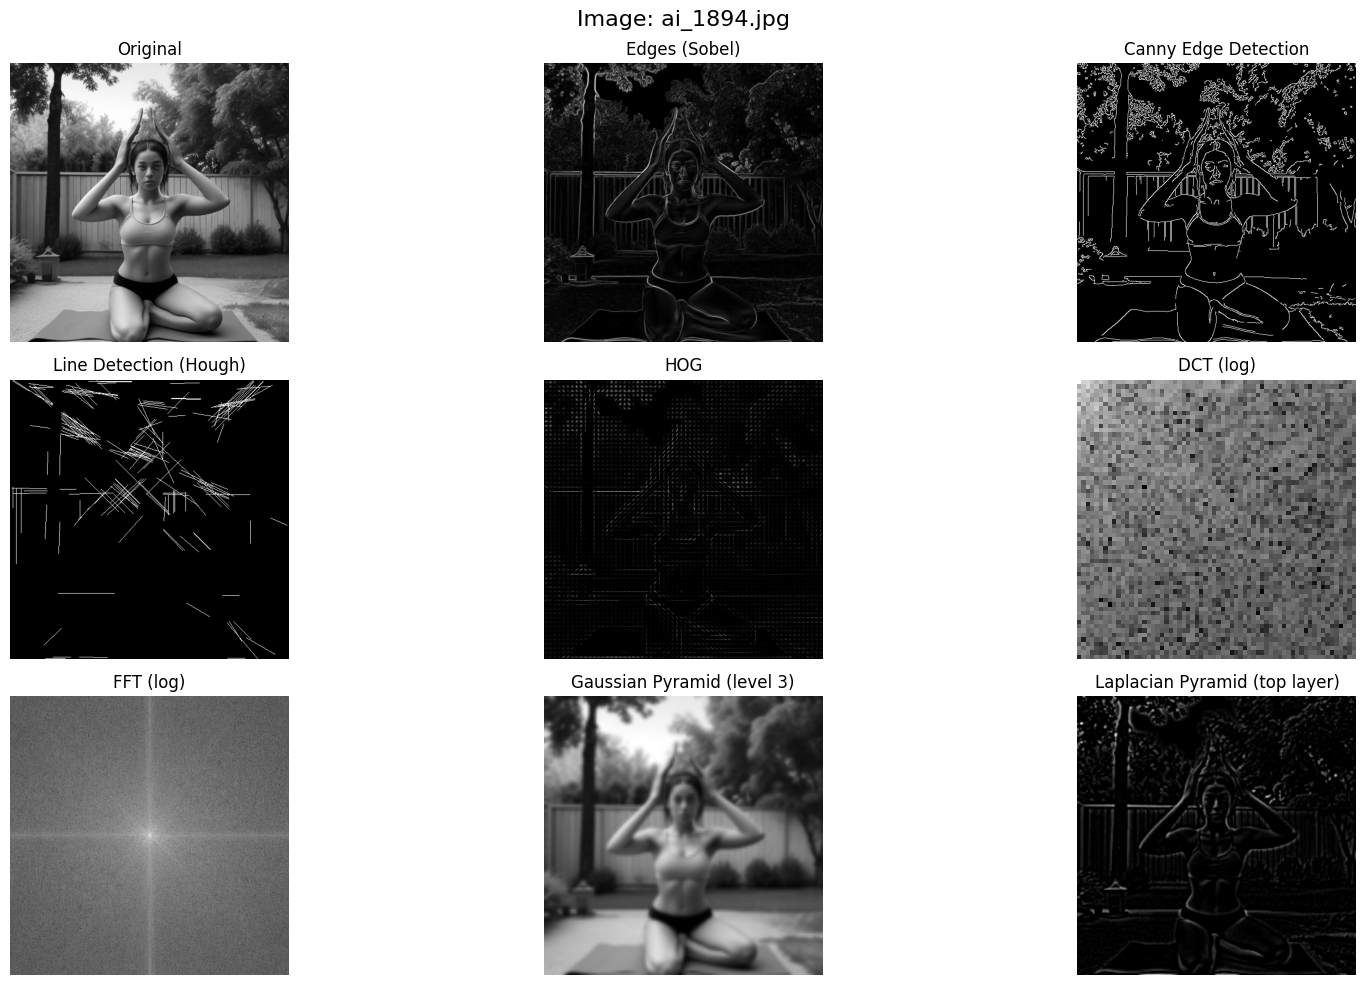

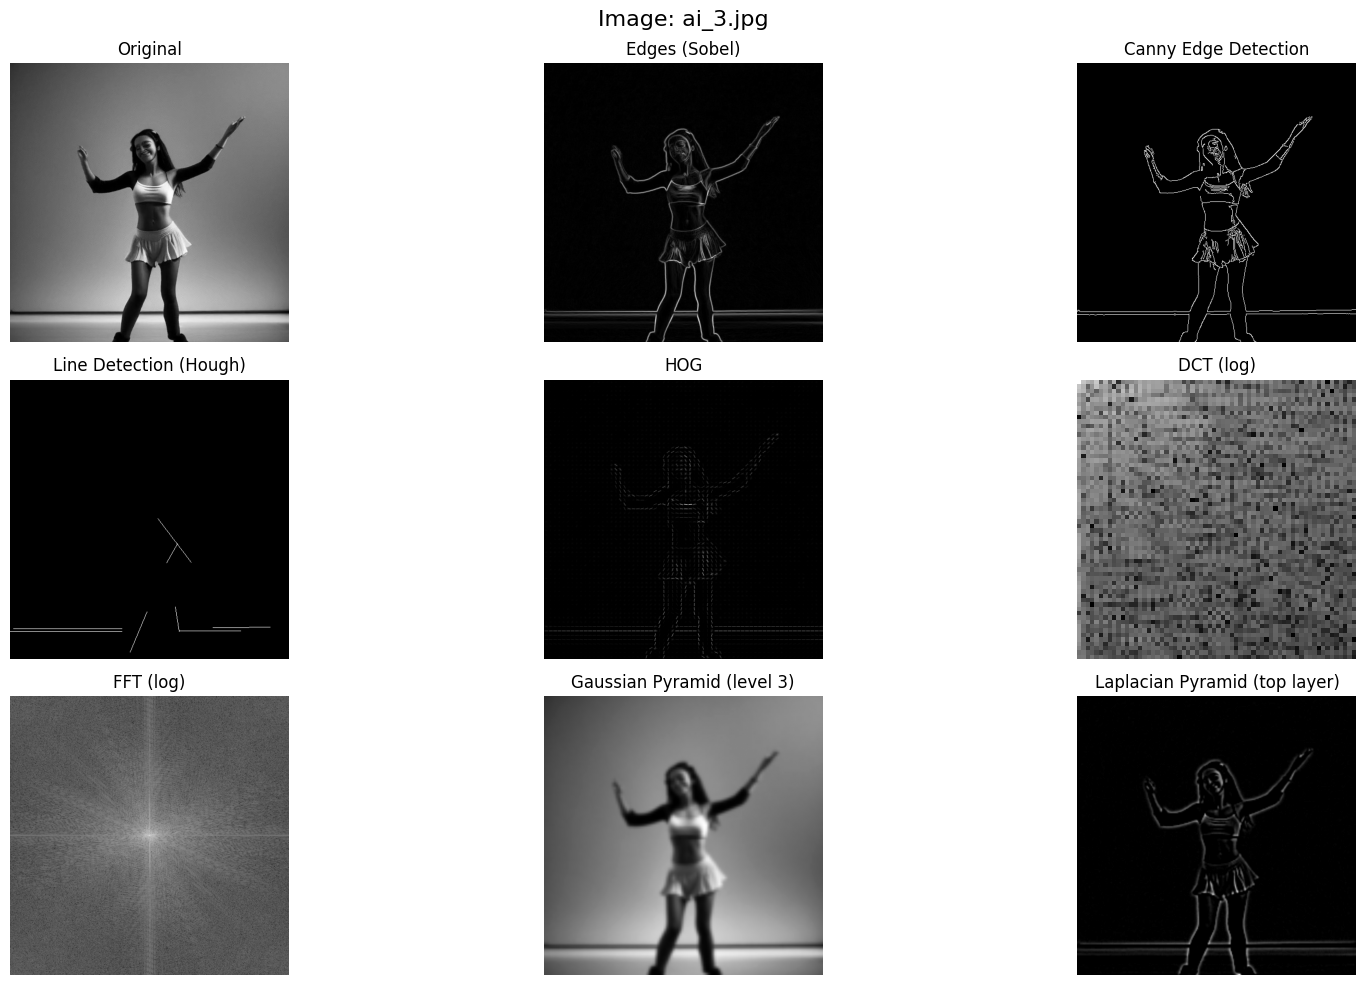

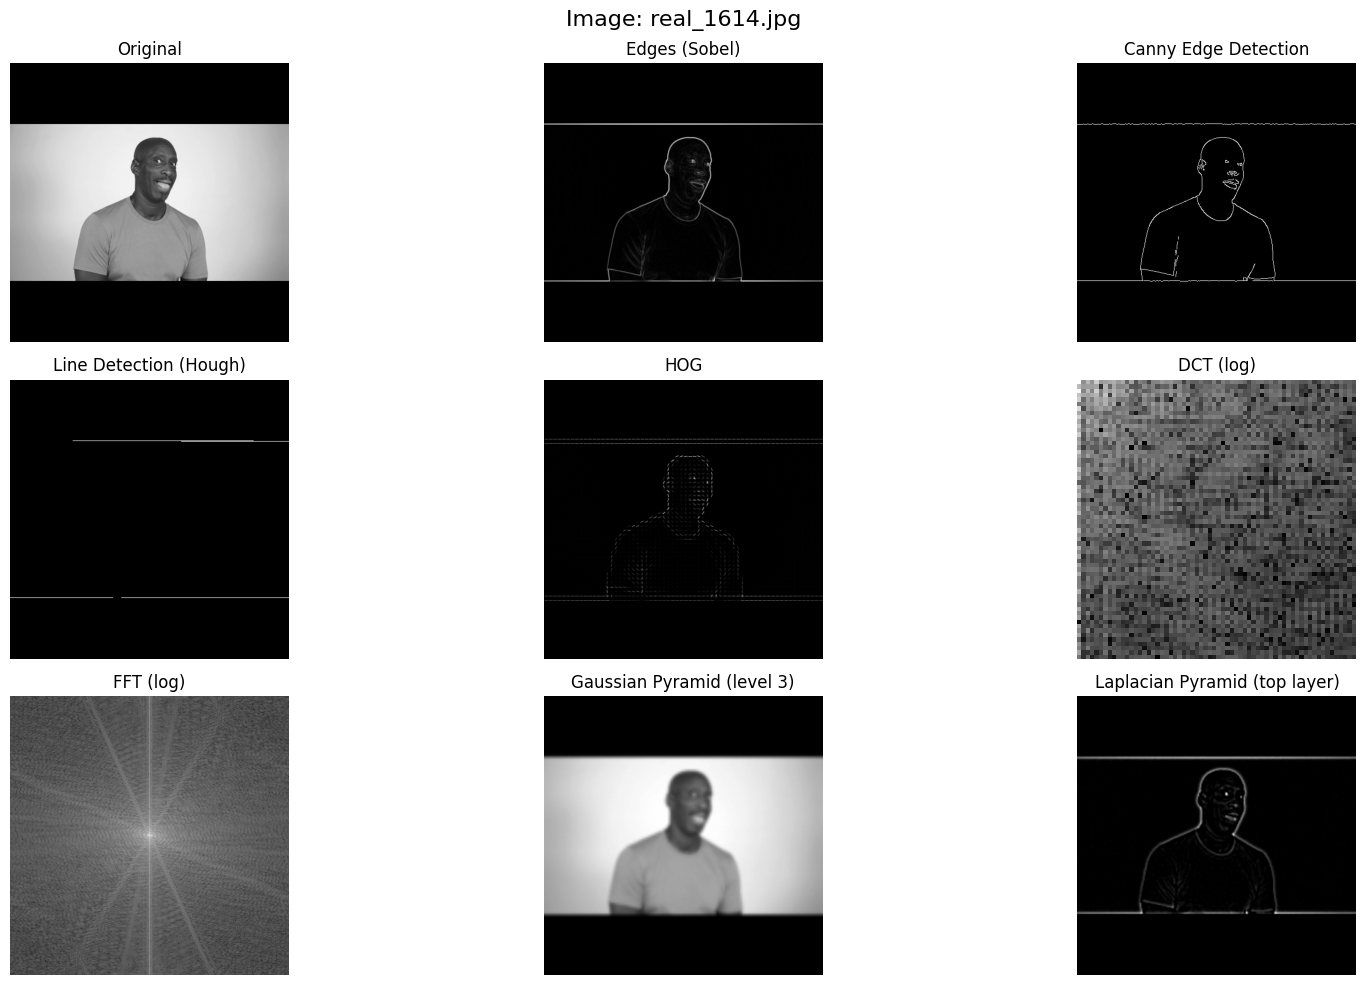

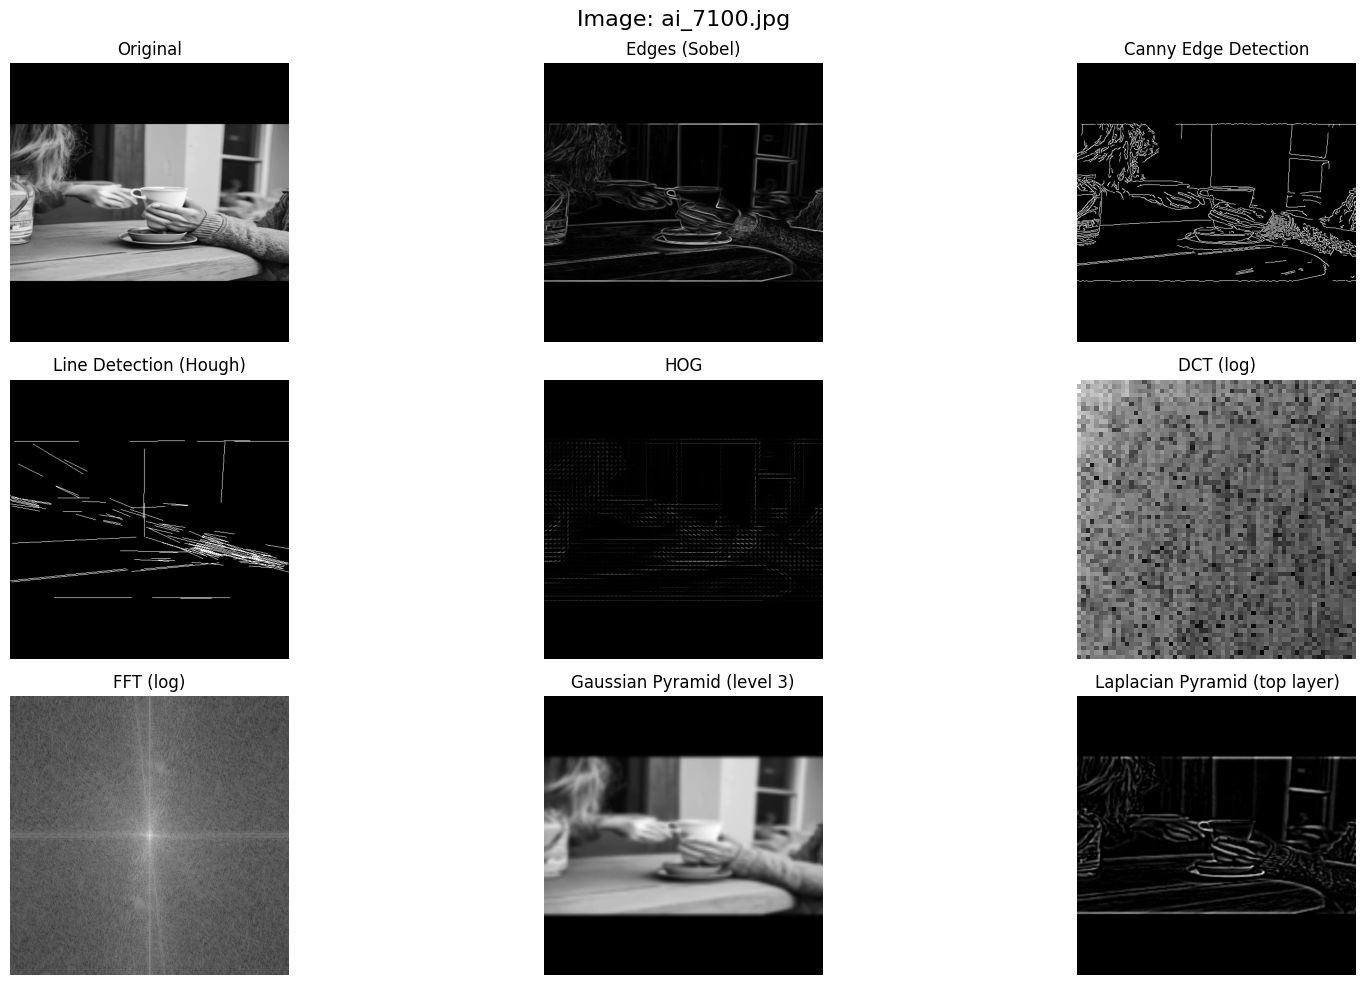

In [4]:
# Feature Extraction Functions
def get_edges(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    return cv2.magnitude(grad_x, grad_y)

def get_canny(img):
    return cv2.Canny(img, 100, 200)

def get_lines(img):
    canny = get_canny(img)
    lines = cv2.HoughLinesP(canny, 1, np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)
    line_img = np.zeros_like(img)
    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(line_img, (x1, y1), (x2, y2), 255, 1)
    return line_img

def get_hog(img, vector_only=False):
    features, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), block_norm='L2-Hys',
                            visualize=True, feature_vector=True)
    return features if vector_only else hog_img

def get_dct(img):
    dct_img = dct(dct(img.astype(float), axis=0, norm='ortho'), axis=1, norm='ortho')
    return np.log(np.abs(dct_img[:64, :64]) + 1)  # crop and log scale

def get_fft(img):
    f = fft2(img)
    fshift = fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    return magnitude

def get_gaussian_pyramid(img, levels=3):
    """
    Builds Gaussian pyramid and upsamples to return a 512x512 image.
    """
    gp = [img.copy()]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        gp.append(img)
    upsampled = cv2.resize(gp[-1], (512, 512), interpolation=cv2.INTER_LINEAR)
    return upsampled

def get_laplacian_pyramid(img, levels=3):
    """
    Builds Laplacian pyramid and upsamples the top layer to 512x512.
    """
    gp = [img.copy()]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        gp.append(img)

    lp = []
    for i in range(levels - 1, 0, -1):
        up = cv2.pyrUp(gp[i])
        up = cv2.resize(up, gp[i-1].shape[::-1])
        lap = cv2.subtract(gp[i-1], up)
        lp.append(lap)
    lap_upsampled = cv2.resize(lp[0], (512, 512), interpolation=cv2.INTER_LINEAR)
    return lap_upsampled


# Loading dataset - using a small subset for experimenting with features (1% only)
df = pd.read_csv("splits/train.csv")
subset_df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)

def visualize_feature_images(img, img_path):
    features = {
        "Original": img,
        "Edges (Sobel)": get_edges(img),
        "Canny Edge Detection": get_canny(img),
        "Line Detection (Hough)": get_lines(img),
        "HOG": get_hog(img),
        "DCT (log)": get_dct(img),
        "FFT (log)": get_fft(img),
        "Gaussian Pyramid (level 3)": get_gaussian_pyramid(img),
        "Laplacian Pyramid (top layer)": get_laplacian_pyramid(img),
    }
    plt.figure(figsize=(18, 10))
    for j, (title, f_img) in enumerate(features.items()):
        plt.subplot(3, 3, j + 1)
        plt.title(title)
        plt.imshow(f_img, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Image: {os.path.basename(img_path)}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizing the first 10 Images with their features
for i in range(10):
    row = subset_df.iloc[i]
    img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
    if img is not None:
        visualize_feature_images(img, row['filepath'])


My initial assumption—based solely on the visualizations (which I know isn't a reliable method)—is that Canny edge detection, HOG, DCT, FFT, and the Laplacian pyramid appear to be effectively capturing information for the images.

#### Visualizing the features using PCA and tSNE

100%|██████████| 139/139 [00:00<00:00, 659.49it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


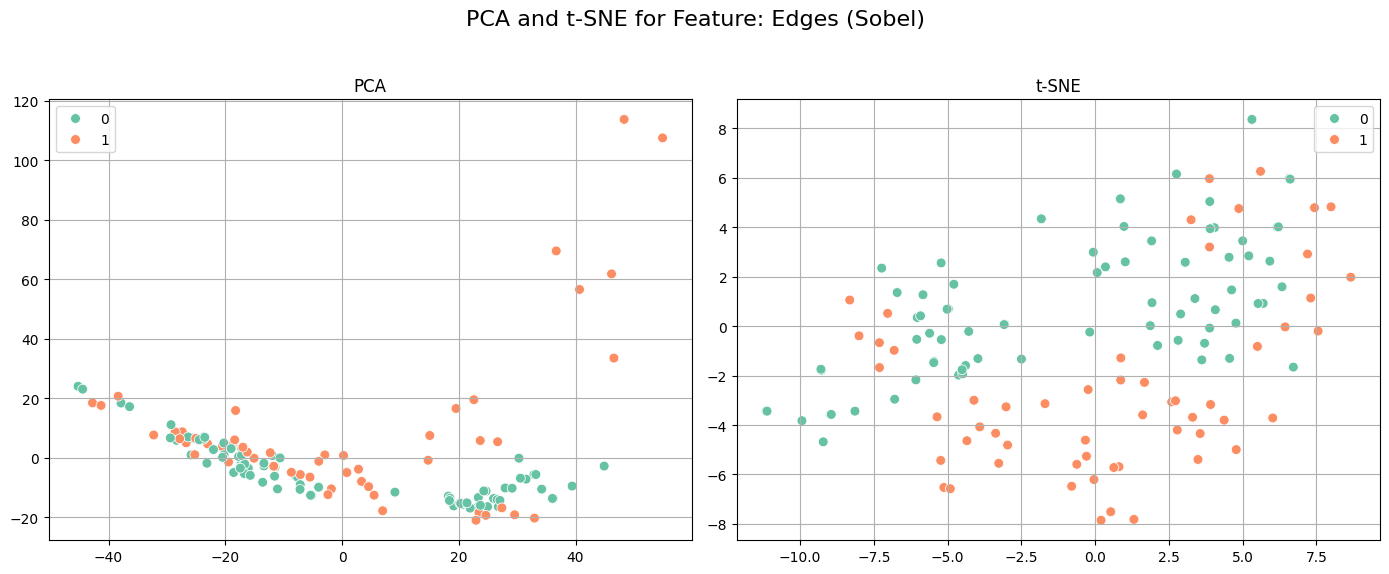

100%|██████████| 139/139 [00:00<00:00, 1013.37it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


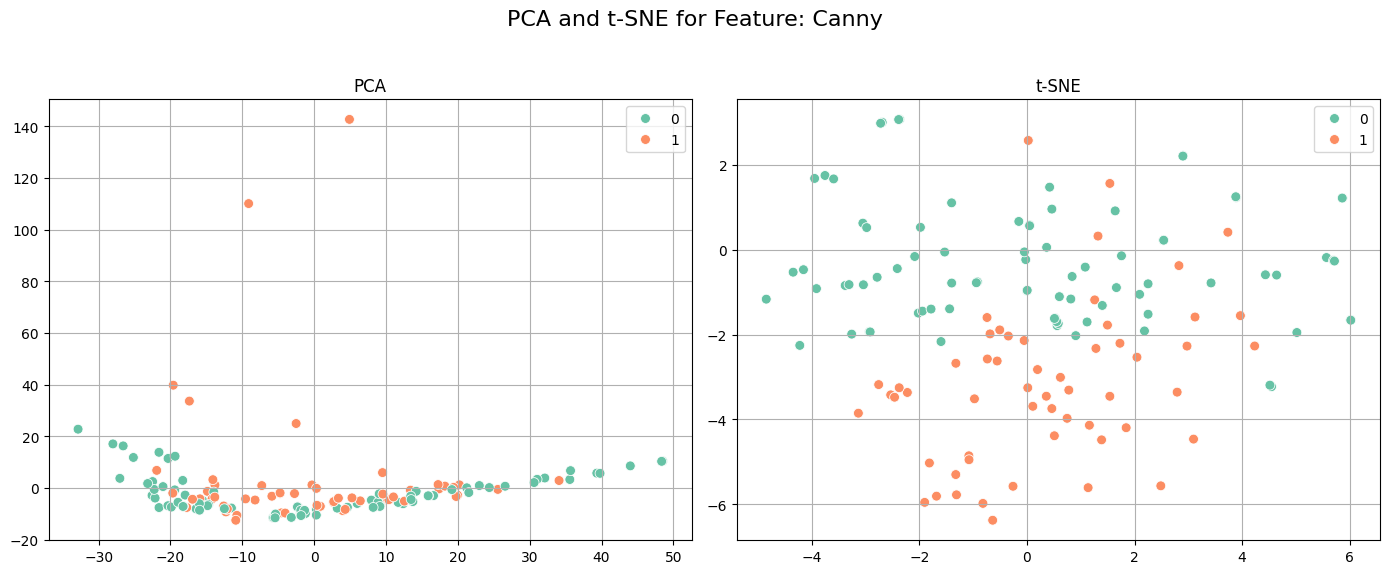

100%|██████████| 139/139 [00:00<00:00, 481.64it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


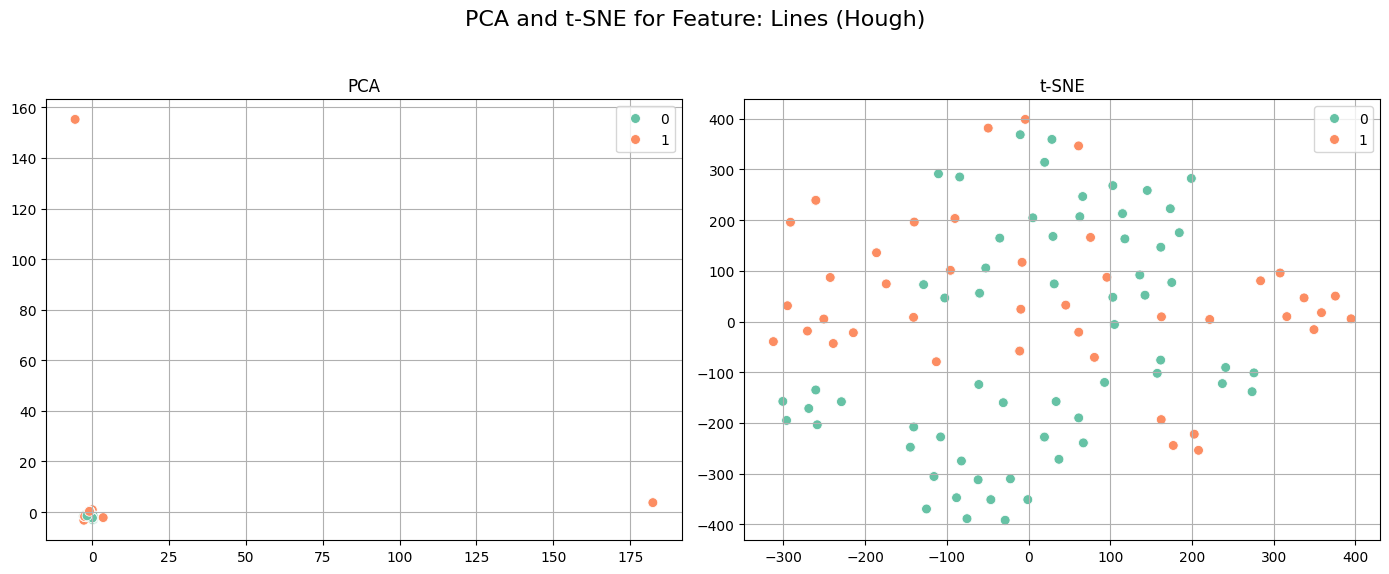

100%|██████████| 139/139 [00:02<00:00, 48.06it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


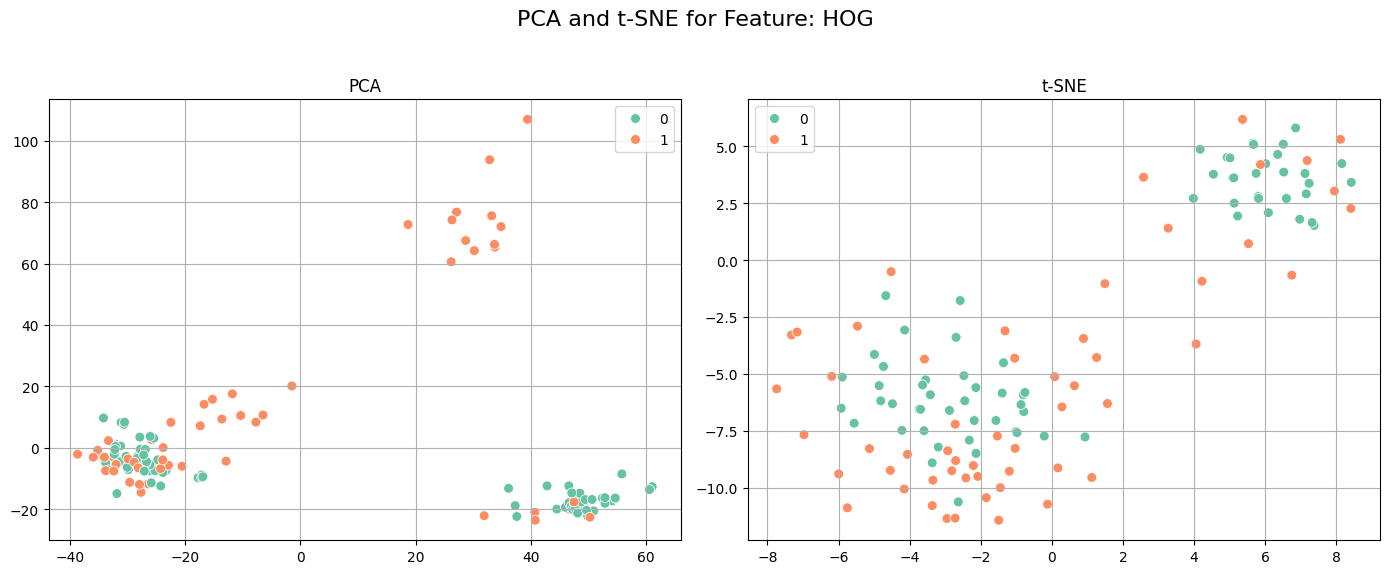

100%|██████████| 139/139 [00:00<00:00, 1020.23it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


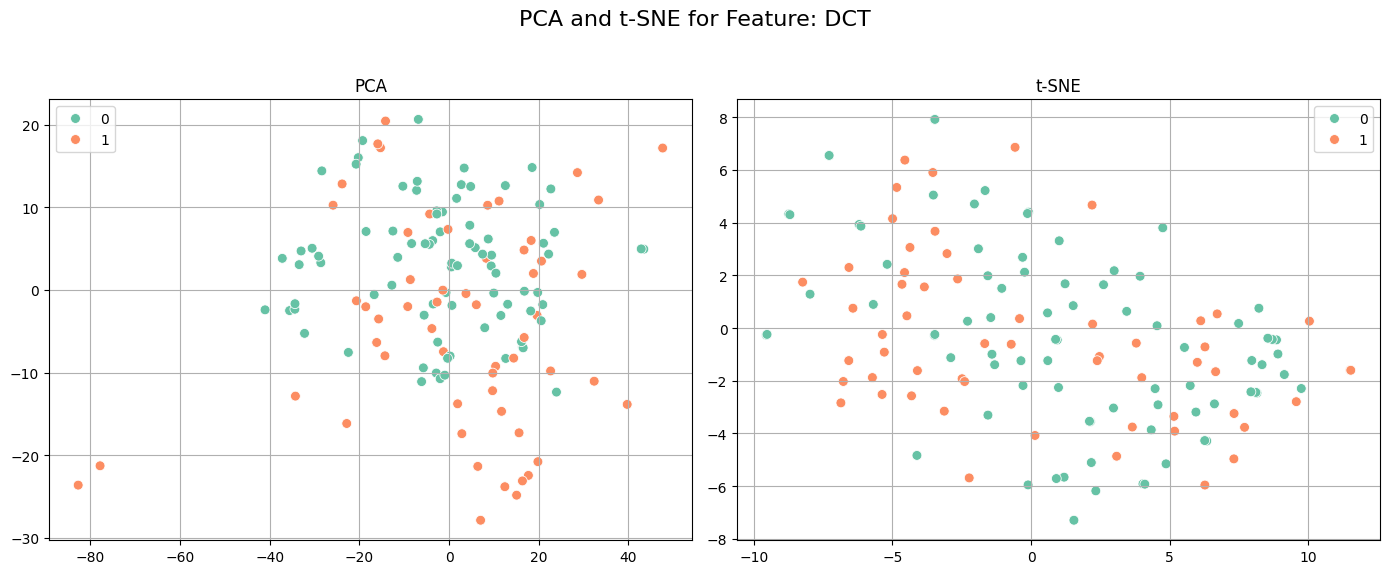

100%|██████████| 139/139 [00:00<00:00, 839.74it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


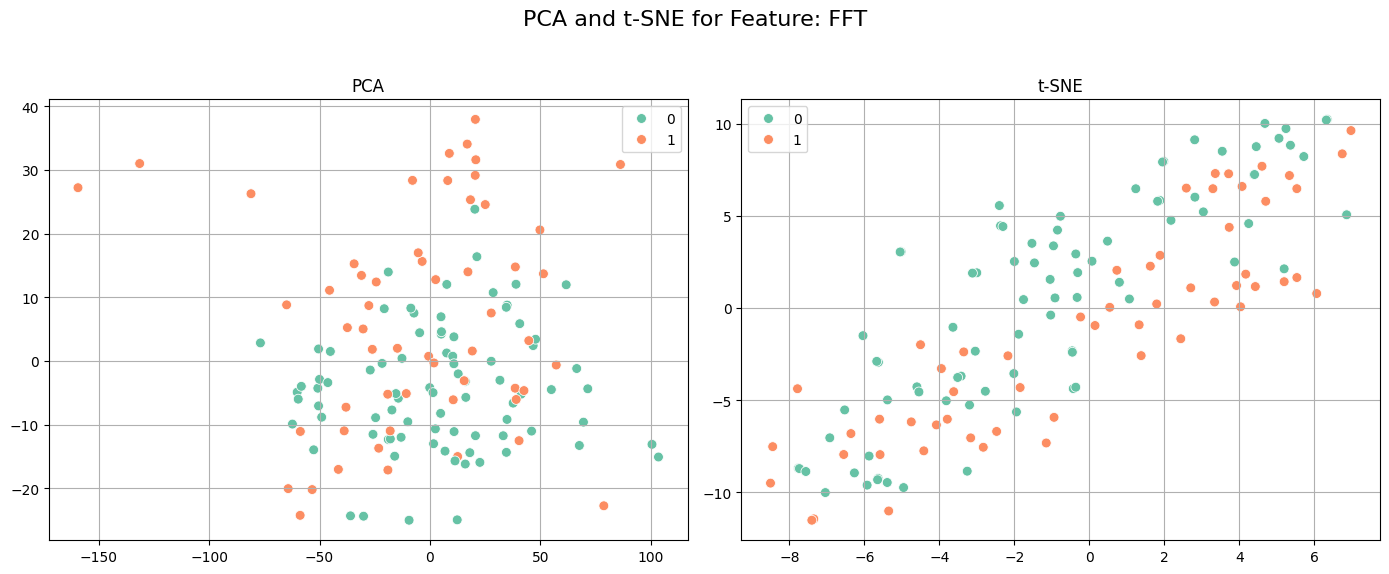

100%|██████████| 139/139 [00:00<00:00, 914.81it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


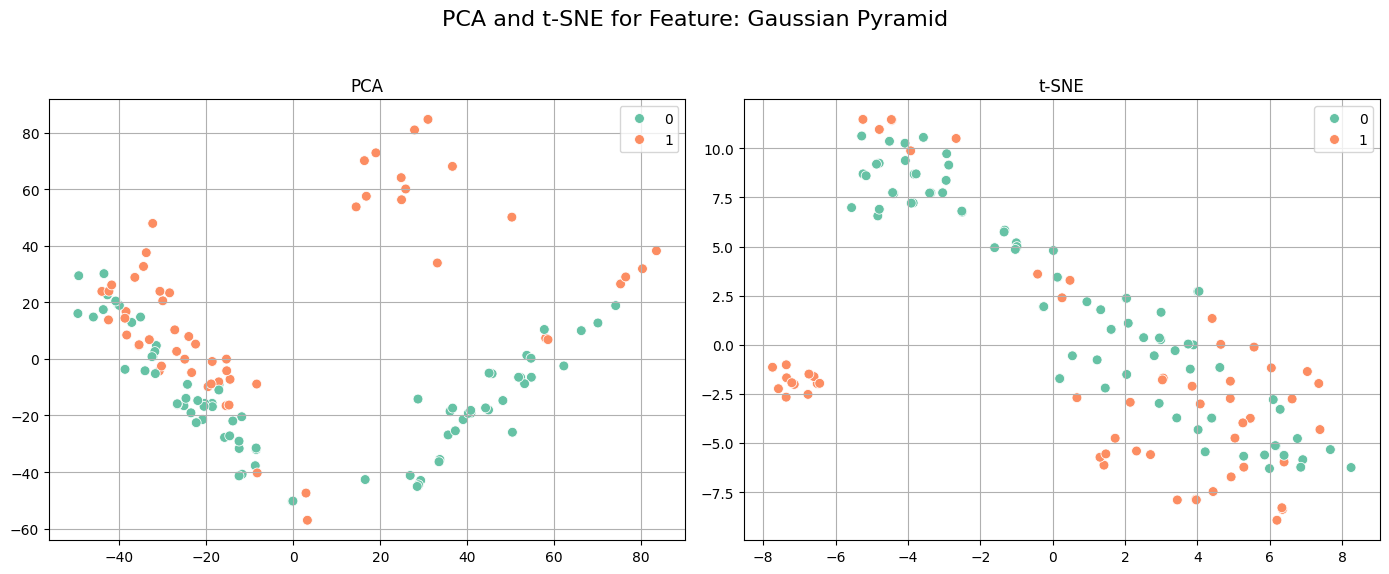

100%|██████████| 139/139 [00:00<00:00, 501.48it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


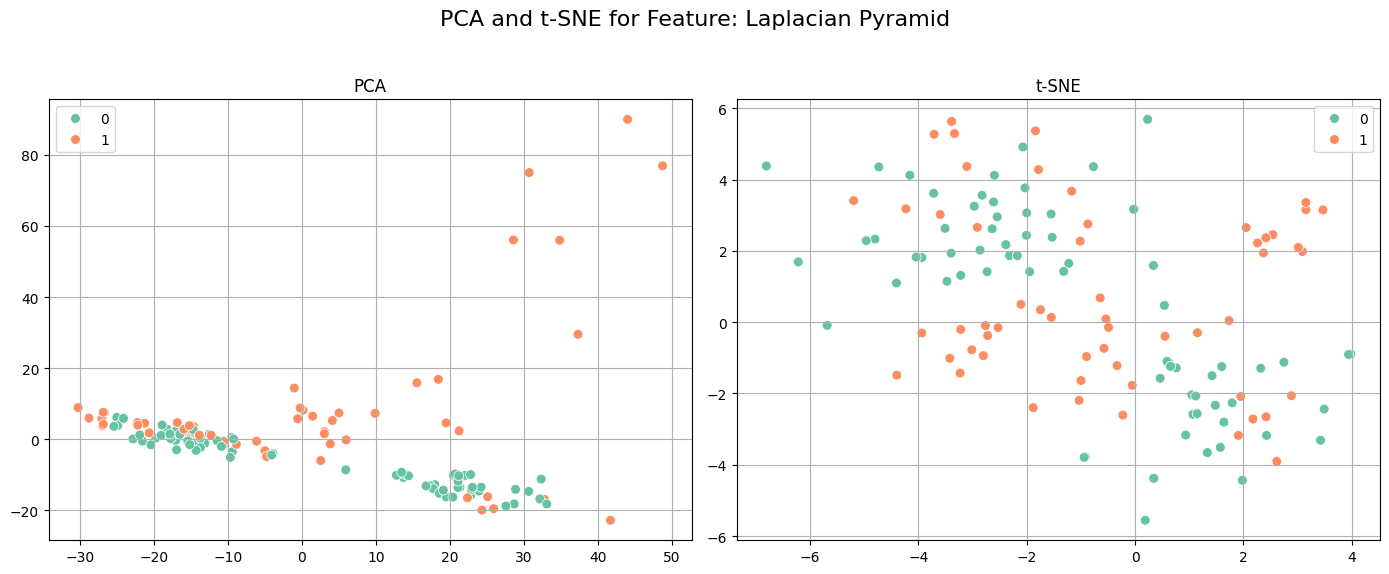

In [6]:
def flatten_feature(img, size=None):
    if size:
        img = cv2.resize(img, size)
    return img.flatten()

def extract_combined_features(img):
    hog_vec = get_hog(img, vector_only=True)
    edge_vec = flatten_feature(get_edges(img), size=(32, 32))
    fft_vec = flatten_feature(get_fft(img), size=(32, 32))
    laplacian_vec = flatten_feature(get_laplacian_pyramid(img), size=(32, 32))
    gaussian_vec = flatten_feature(get_gaussian_pyramid(img), size=(32, 32))
    return np.concatenate([hog_vec, edge_vec, fft_vec, laplacian_vec, gaussian_vec])

def visualize_feature_reduction(X_feat, y_labels, feature_name):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_feat)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"PCA and t-SNE for Feature: {feature_name}", fontsize=16)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_labels, palette='Set2', s=50, ax=axes[0])
    axes[0].set_title("PCA")
    axes[0].grid(True)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette='Set2', s=50, ax=axes[1])
    axes[1].set_title("t-SNE")
    axes[1].grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

feature_functions = {
    "Edges (Sobel)": lambda img: flatten_feature(get_edges(img), size=(64, 64)),
    "Canny": lambda img: flatten_feature(get_canny(img), size=(64, 64)),
    "Lines (Hough)": lambda img: flatten_feature(get_lines(img), size=(64, 64)),
    "HOG": lambda img: get_hog(img, vector_only=True),
    "DCT": lambda img: flatten_feature(get_dct(img), size=(64, 64)),
    "FFT": lambda img: flatten_feature(get_fft(img), size=(64, 64)),
    "Gaussian Pyramid": lambda img: flatten_feature(get_gaussian_pyramid(img), size=(64, 64)),
    "Laplacian Pyramid": lambda img: flatten_feature(get_laplacian_pyramid(img), size=(64, 64)),
}

for name, func in feature_functions.items():
    X_feat, y_labels = [], []
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_feat.append(func(img))
        y_labels.append(row['label'])
    visualize_feature_reduction(np.array(X_feat), y_labels, name)

### Individual Features PCA and t-SNE Observations

#### 1. Edges (Sobel)
##### PCA
* Some linear trend is present, but the variance across PC1 and PC2 is not clearly separable between the two classes.
* Outliers in Class 1 (top-right corner) suggest there could be some distinct structural edge patterns in certain AI images.

##### t-SNE
* Better clustering than PCA: we can observe partial separation of the classes.
* Class 0 tends to occupy upper-right and central areas, while Class 1 is more prominent in the lower-left and lower-right.
* Overlap still exists, but the feature look like they contribute to nonlinear separability between classes.

There is better class separation in t-SNE than PCA, which suggests that it is more non-linear so a non-linear classifier might perform better for this feature.


#### 2. Edges (Canny)
##### PCA
* There is some separation, but a large overlap between the two classes.
* A few outliers in Class 1 (AI) with very high PC2 values (above 100) suggest extreme edge response in some generated images.
* Most points cluster around the horizontal axis, indicating low variance in PC2 for many samples.

##### t-SNE
* Shows better separation than PCA, especially along Dim 2:
* Class 0 (real) tends to populate the upper and central regions.
* Class 1 (AI) is more dominant in the lower half, suggesting some degree of nonlinear separation.

A substantial overlap in the center means this feature alone won’t be a strong discriminator. But could be used for a non-linear classifier.


#### 3. Line Detection
##### PCA
* Highly skewed distribution — nearly all points are concentrated around the origin (0,0), with a few extreme outliers.
* Most images dont seem to have prominent line structures, so this feature would not be useful for classifying.

##### t-SNE
* The data is widely dispersed in both dimensions, suggesting variability in the feature.
* No clear separation is visible — both classes are intermixed across the entire plot.
* Even from the t-SNE we cannot find any pattern or trend, so this isn't a good feature.


#### 4. HOG
##### PCA
* Distinct clustering is visible. There's a tight cluster on the far left, with a mix of both classes. A more separated group appears at PC1 ≈ +40 to +60, mostly containing Class 1 (AI).
* This suggests HOG captures structural or texture patterns that are somewhat unique to AI-generated images.
* This indicates that this feature has strong linear discriminative power.

##### t-SNE
* A clearer separation appears:
Class 0 (real) is mostly clustered toward the top right and center.
Class 1 (AI) tends to cluster more toward the bottom left, especially in the negative range of both dimensions.
* t-SNE reveals nonlinear class boundaries, but overall class clustering is strong.

From PCA and t-SNE we can see that HOG is a good discriminative feature in our datset and hence can mwork with both linear and non-linear models.


#### 5. DCT(log)
##### PCA
* Data is very centered around (0,0), with strong overlap between Class 0 and Class 1.
* There's no clear linear separation — both classes are heavily mixed

##### t-SNE
* Shows slightly more structure than PCA, but still both classes are widely interspersed.
* No distinct clusters or edges specific to either class.

So this might not be a good feature to use

#### 6. FFT(log)
##### PCA
* Both Class 0 (real) and Class 1 (AI) are heavily overlapped in the central region.
* Linear separation is weak.

##### t-SNE
* Shows significantly better structure than PCA.
* There's a clear diagonal gradient from bottom-left to top-right.
* Class 0 (real) populates more of the upper-right quadrant, while Class 1 (AI generated) dominates the lower-left.
* This suggests FFT captures nonlinear frequency-based differences that help discriminate between classes.

So we can use FFT for a non-linear model.


#### 7. Gaussian Pyramid(level 3)
##### PCA
* There is a strong V-shaped trend in the data
* Class 0 (real) tends to occupy the bottom-right of the V, while Class 1 (AI) is more frequent at the top-left and top-right arms.
* While there's still some overlap near the center, the spread is wide, and class trends are distinct.
* PCA shows a (piecewise) linear separation trend.

##### t-SNE
* Class 0 (real) is clustered at the top-left and center.
* Class 1 (ai generated) dominates the bottom-right quadrant.
* There's a strong diagonal structure — classes distribute almost along opposing ends.

The Gaussian pyramid captures low-frequency image structure, texture, and blur — which may differ significantly between real and AI-generated images, especially since generated images often show texture regularities or unnatural smoothness.
This feature exhibits strong discriminative power, both linearly (PCA) and nonlinearly (t-SNE).
So it work well with a linear and non-linear model


#### 8. Laplacian Pyramid(top layer)
##### PCA
* There is a clear horizontal trend, where Class 0 (real) concentrates on the right side, and Class 1 (ai generated) is more spread out but tends toward the left side (PC1 < 0).
* Outliers in Class 1 (upper-right region) suggest that some AI-generated images produce unusually high Laplacian responses (maybe due to artifacts or overly sharp transitions).
* The separation in PC1 is moderate but noticeable, indicating some linear discriminative power.

##### t-SNE
* Mixed class distribution overall.
* Subtle structure exist.
    Class 0 (real) leans more toward right and lower half.
    Class 1 (ai-generated) is concentrated near center and upper-left.

The Laplacian pyramid emphasizes high-frequency detail — fine textures and edges.
It might be a good to compliment it with another feature like  Gaussian pyramid (low-frequency structure) and HOG (mid-frequency gradient detail).

1394it [00:01, 725.28it/s]                         
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


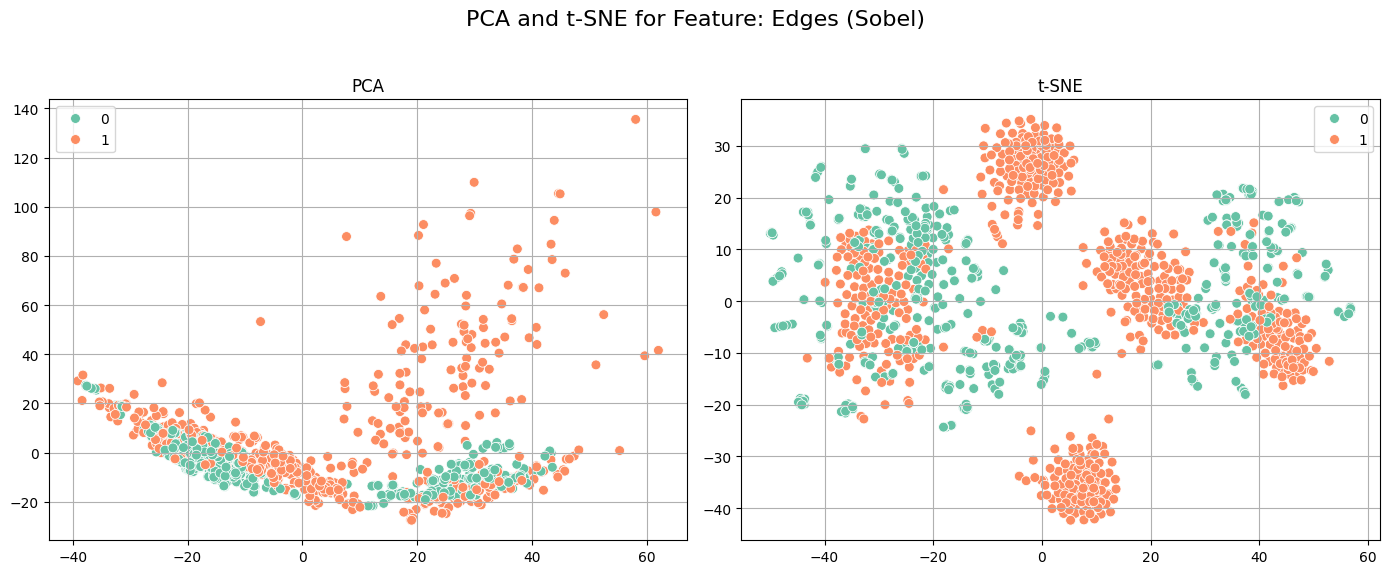

1394it [00:01, 964.92it/s]                       
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


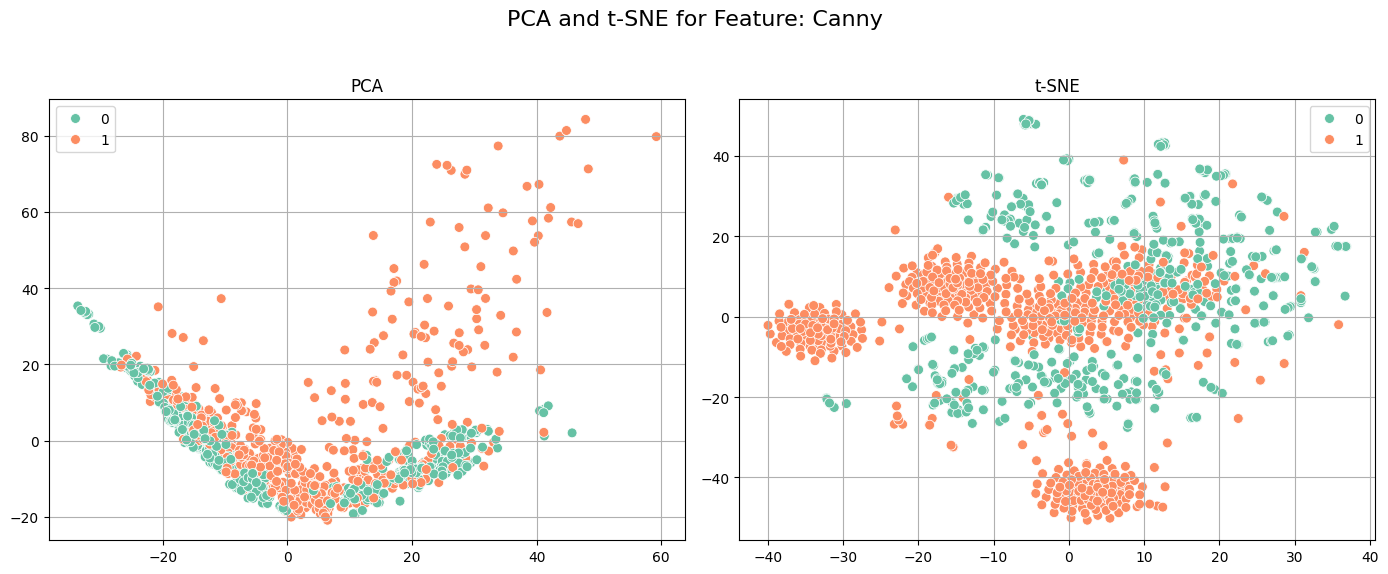

1394it [00:02, 668.55it/s]                        
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


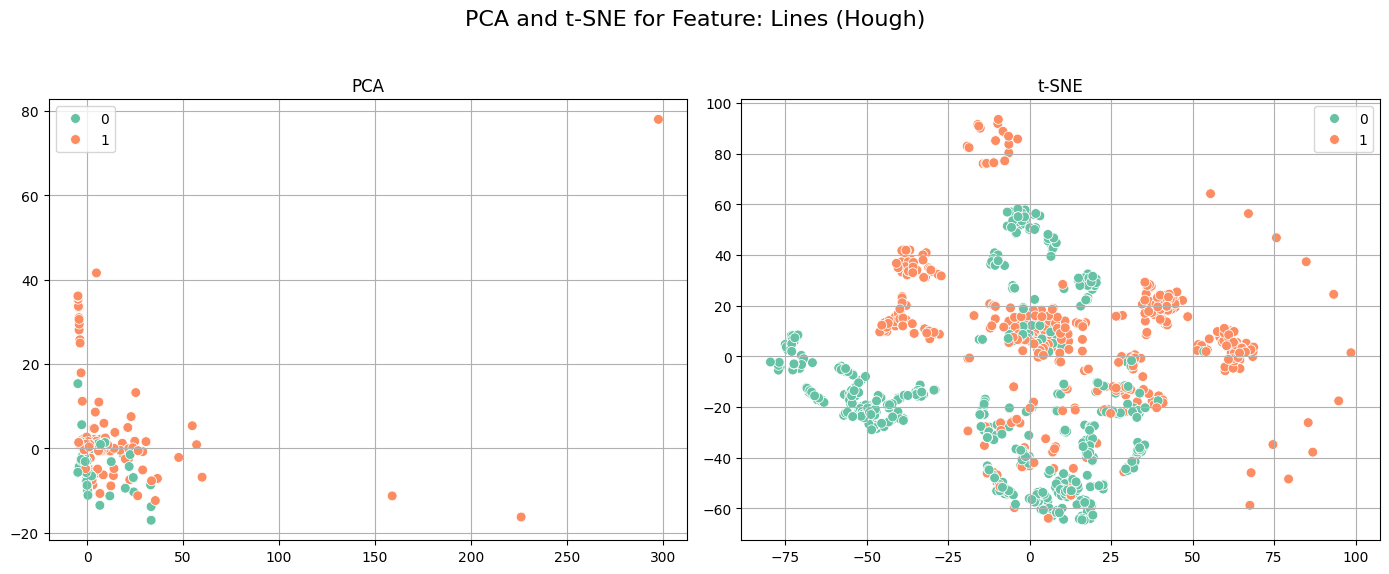

1394it [00:28, 49.17it/s]                        
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


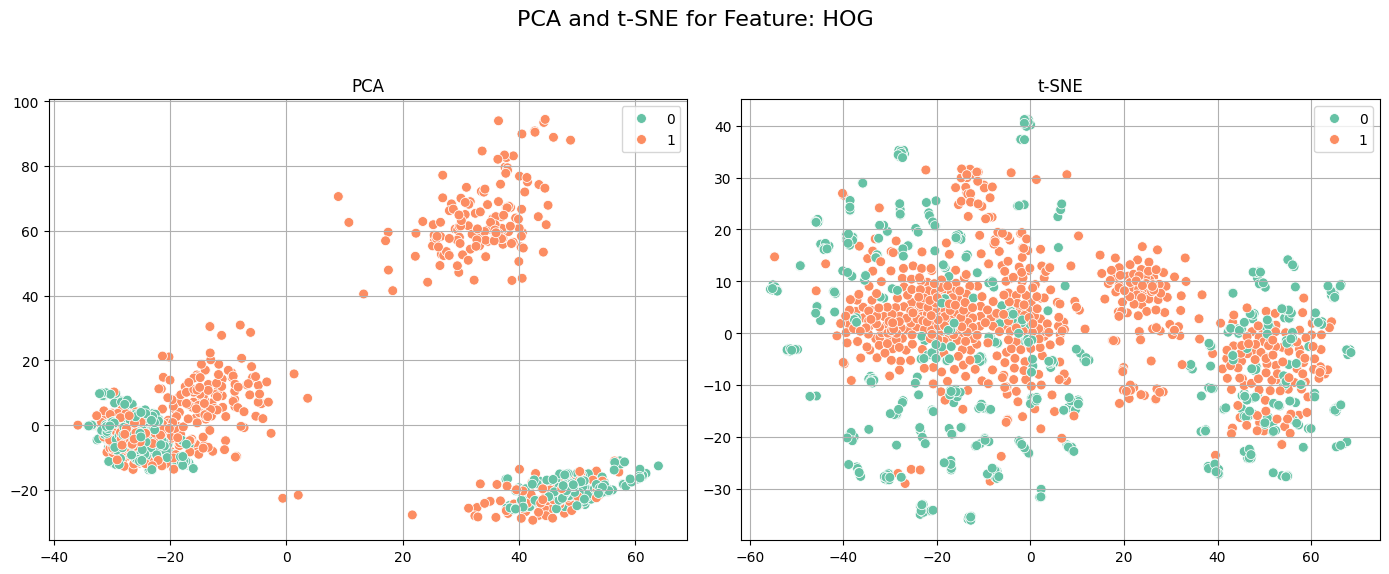

1394it [00:01, 747.23it/s]                       
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


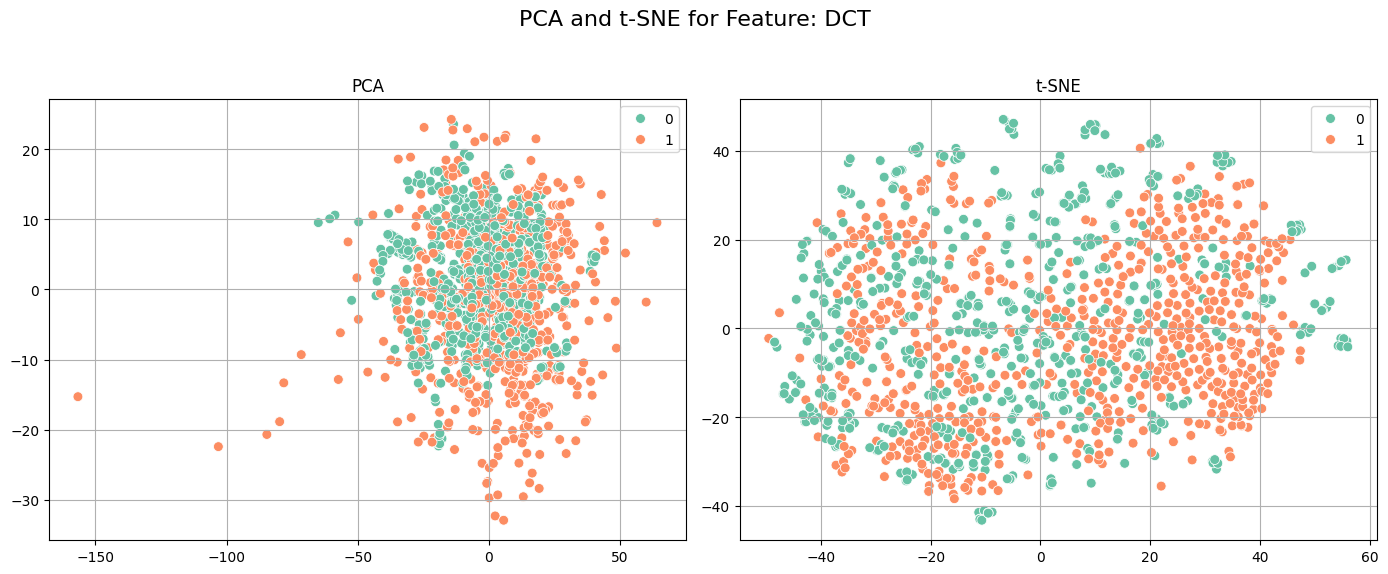

1394it [00:01, 788.14it/s]                       
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


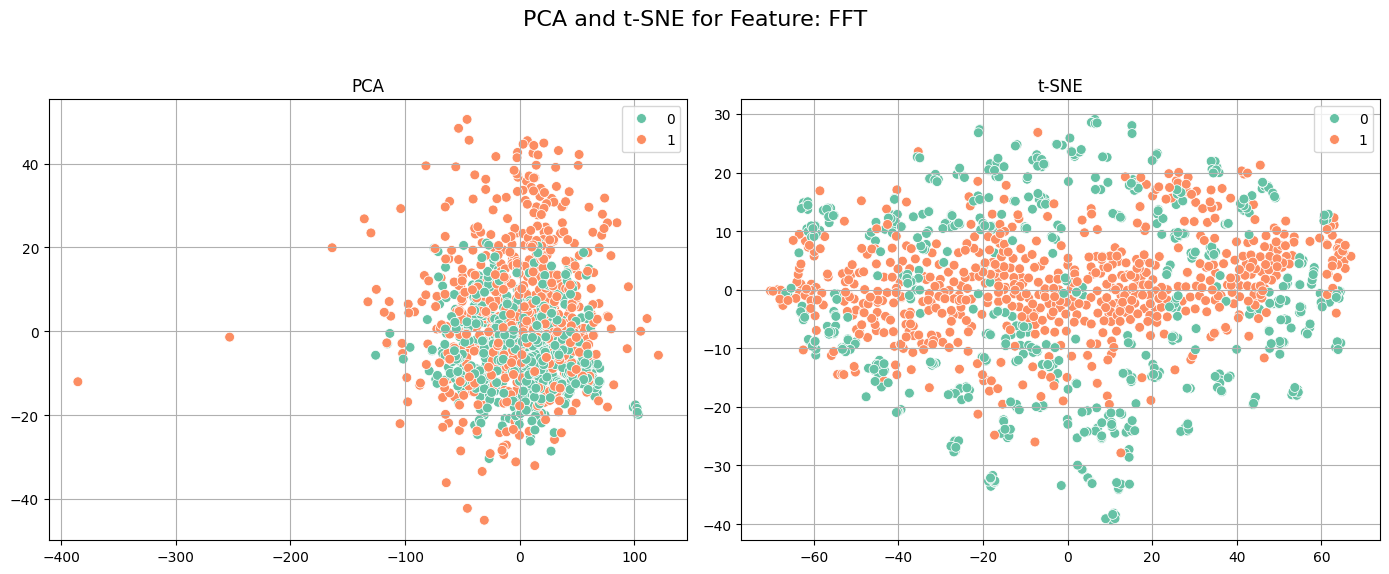

1394it [00:01, 1119.90it/s]                        
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


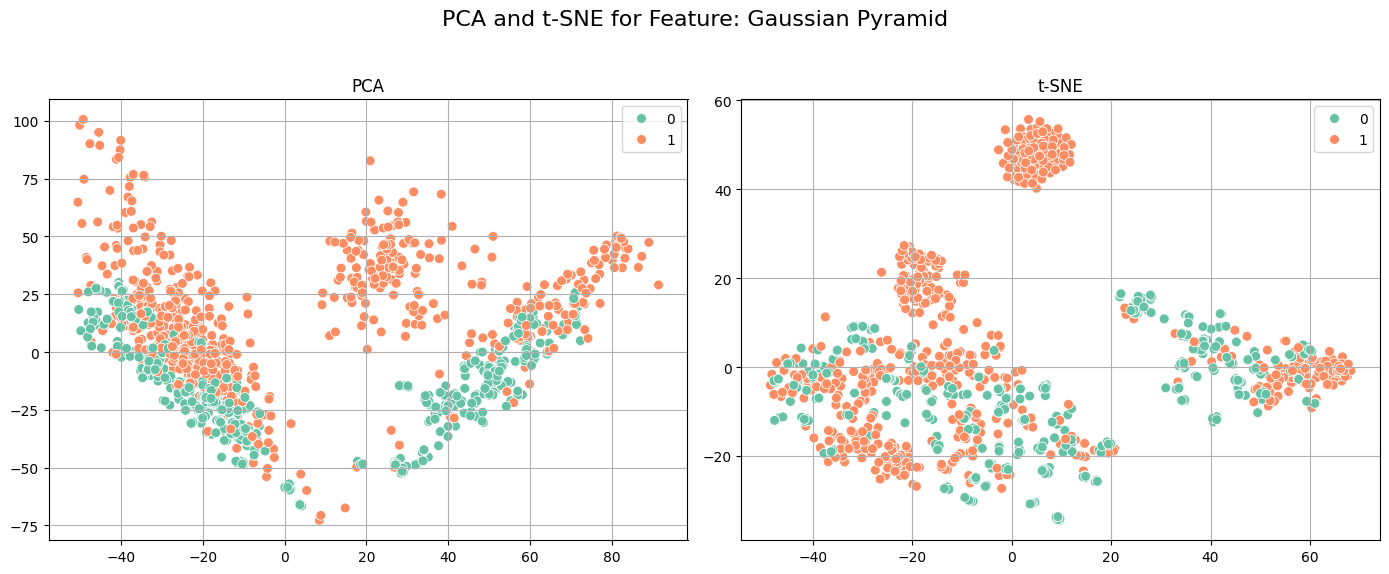

1394it [00:01, 1088.64it/s]                      
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


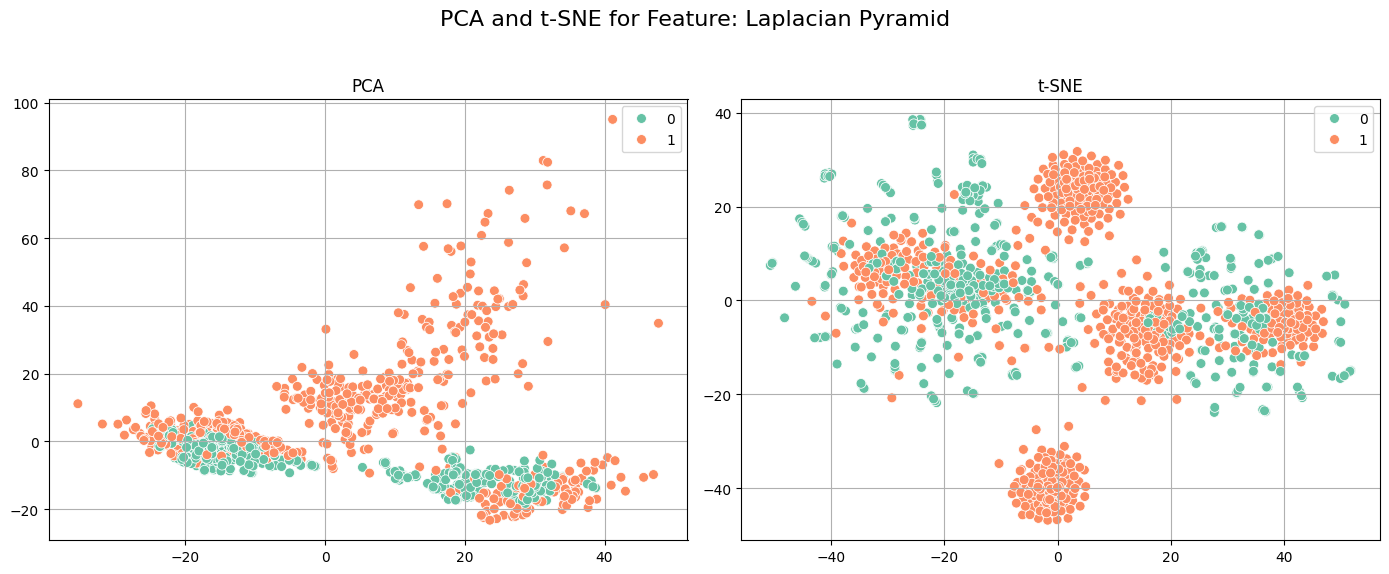

In [7]:
subset2_df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
for name, func in feature_functions.items():
    X_feat, y_labels = [], []
    for _, row in tqdm(subset2_df.iterrows(), total=len(subset_df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_feat.append(func(img))
        y_labels.append(row['label'])
    visualize_feature_reduction(np.array(X_feat), y_labels, name)

100%|██████████| 139/139 [00:03<00:00, 42.68it/s]
/Users/devisivakumar/MyClasses/Spring 2025/290T CompVision/cvvenv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


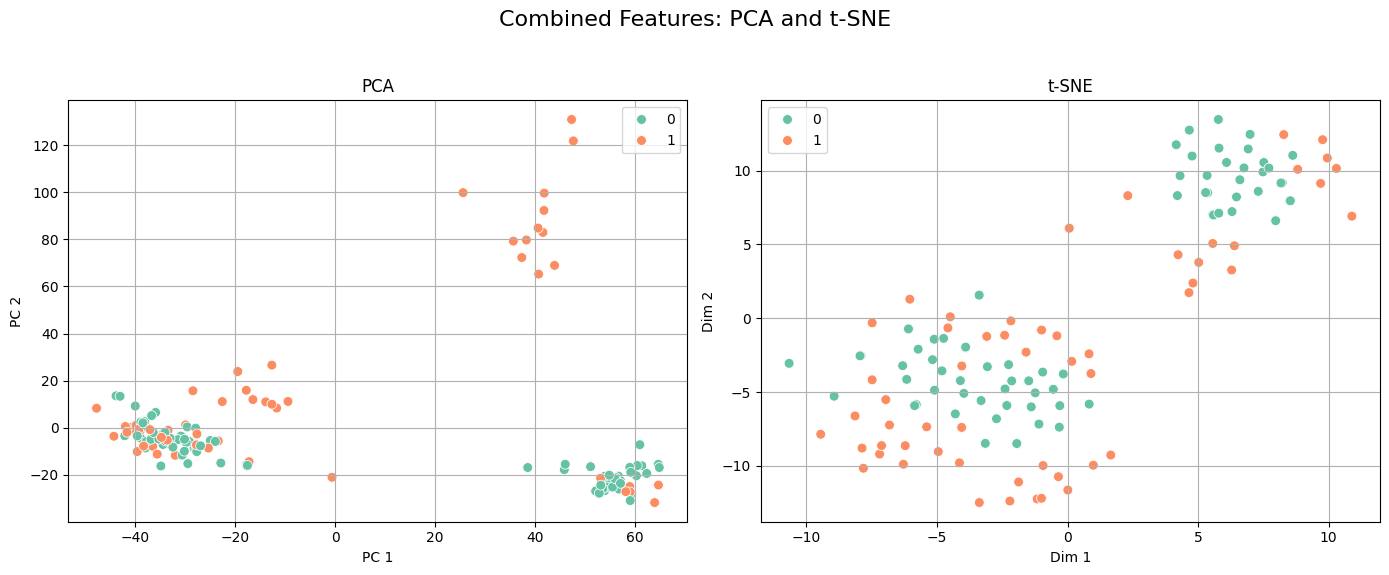

In [29]:
def extract_combined_features(img):
    hog_vec = get_hog(img, vector_only=True)
    edge_vec = flatten_feature(get_edges(img), size=(32, 32))
    fft_vec = flatten_feature(get_fft(img), size=(32, 32))
    laplacian_vec = flatten_feature(get_laplacian_pyramid(img), size=(32, 32))
    gaussian_vec = flatten_feature(get_gaussian_pyramid(img), size=(32, 32))
    return np.concatenate([hog_vec, edge_vec, fft_vec, laplacian_vec, gaussian_vec])


#  Build Feature Matrix for Subset
X = []  # feature vectors
y = []  # labels

for _, row in tqdm(subset_df.iterrows(), total=len(subset_df)):
    img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    img = cv2.resize(img, (128, 128))
    features = extract_combined_features(img)
    X.append(features)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

# Normalize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualizing PCA and t-SNE for Combined Features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Combined Features: PCA and t-SNE", fontsize=16)

# applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', s=50, ax=axes[0])
axes[0].set_title("PCA")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[0].grid(True)

# applying t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=50, ax=axes[1])
axes[1].set_title("t-SNE")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### PCA and t-SNE on top 5 Features
#### PCA Observations
* Class 0 (real) forms a tight cluster on the left side.
* Class 1 (AI) is more dispersed, with several data points forming distinct groups on the right.
* A large group of Class 1 samples appears isolated (top-right quadrant) — suggesting some unique patterns captured across combined features.
* This indicates strong linear separability, better than any single-feature PCA we did.


#### t-SNE Observations
* Class 0 (real) dominates the upper-left quadrant, forming a dense cluster.
* Class 1 (ai-generated) mostly occupies the lower-right half, with minor overlap.

Combining these 5 features has successfully maximized variance and class separability — both in linear (PCA) and nonlinear (t-SNE) projections.

In [39]:
labels = ["Real", "AI-generated"]

def print_confusion(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix ({name}):")
    print(pd.DataFrame(cm, index=labels, columns=labels))

# Classifier Training and Evaluation 
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Classifier 1: non-linear SVM 
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)
y_proba_svm = svm.predict_proba(X_val)[:, 1]
print("\n SVM Performance")
print(classification_report(y_val, y_pred_svm, target_names=["Real", "AI-generated"]))
print_confusion("SVM (RBF)", y_val, y_pred_svm)
print("\n ==========================")
# Classifier 2: Linear SVM 
svm_linear = SVC(kernel='linear', C=1, probability=True)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_val)
y_proba_linear = svm_linear.predict_proba(X_val)[:, 1]
print("\n SVM (Linear Kernel) Performance")
print(classification_report(y_val, y_pred_linear, target_names=["Real", "AI-generated"]))
print_confusion("SVM (Linear)", y_val, y_pred_linear)
print("\n ==========================")
# Classifier 3: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_val)
y_proba_logreg = logreg.predict_proba(X_val)[:, 1]
print("\n Logistic Regression Performance")
print(classification_report(y_val, y_pred_logreg, target_names=["Real", "AI-generated"]))
print_confusion("Logistic Regression", y_val, y_pred_logreg)
print("\n ==========================")
# Classifier 4: Least Squares
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_scores_lsq = linreg.predict(X_val)
y_pred_lsq = (y_scores_lsq >= 0.5).astype(int)
print("\n Least Squares Performance")
print(classification_report(y_val, y_pred_lsq, target_names=["Real", "AI-generated"]))
print_confusion("Least Squares", y_val, y_pred_lsq)


 SVM Performance
              precision    recall  f1-score   support

        Real       0.89      1.00      0.94        17
AI-generated       1.00      0.82      0.90        11

    accuracy                           0.93        28
   macro avg       0.95      0.91      0.92        28
weighted avg       0.94      0.93      0.93        28


Confusion Matrix (SVM (RBF)):
              Real  AI-generated
Real            17             0
AI-generated     2             9


 SVM (Linear Kernel) Performance
              precision    recall  f1-score   support

        Real       0.94      1.00      0.97        17
AI-generated       1.00      0.91      0.95        11

    accuracy                           0.96        28
   macro avg       0.97      0.95      0.96        28
weighted avg       0.97      0.96      0.96        28


Confusion Matrix (SVM (Linear)):
              Real  AI-generated
Real            17             0
AI-generated     1            10


 Logistic Regression Perform

#### Analysis of Classification Report and Confusion Matrix
After evaluating four classifiers using top-5 features (HOG, Gaussian Pyramid, Laplacian Pyramid, FFT, Sobel Edges), I observed that SVM with a linear kernel and Least Squares classifiers provided the most reliable and balanced performance. Both achieved 96% accuracy, perfect recall for real images, and only one misclassification of AI-generated images.

In contrast, SVM with RBF kernel, while strong overall, exhibited a slightly lower recall for AI images (82%), and Logistic Regression showed the most misclassifications, with noticeable performance drop in AI detection precision. 

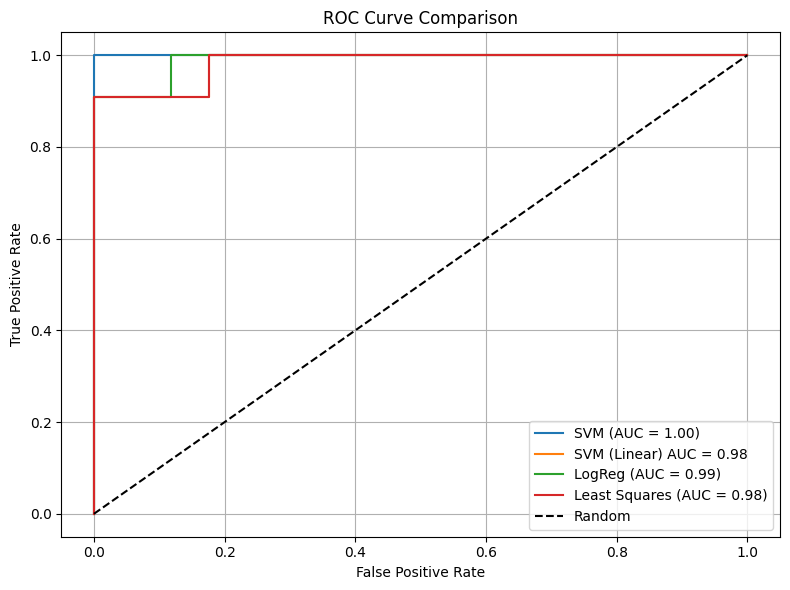

In [31]:
# ROC Curve Comparison
fpr_svm, tpr_svm, _ = roc_curve(y_val, y_proba_svm)
fpr_lin, tpr_lin, _ = roc_curve(y_val, y_proba_linear)
fpr_log, tpr_log, _ = roc_curve(y_val, y_proba_logreg)
fpr_lsq, tpr_lsq, _ = roc_curve(y_val, y_scores_lsq)

auc_svm = auc(fpr_svm, tpr_svm)
auc_lin = auc(fpr_lin, tpr_lin)
auc_log = auc(fpr_log, tpr_log)
auc_lsq = auc(fpr_lsq, tpr_lsq)

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot(fpr_lin, tpr_lin, label=f"SVM (Linear) AUC = {auc_lin:.2f}")
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC = {auc_log:.2f})")
plt.plot(fpr_lsq, tpr_lsq, label=f"Least Squares (AUC = {auc_lsq:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

##### ROC Analysis
* SVM (RBF) achieves a perfect AUC of 1.00, indicating it ranks positive (AI) samples above negatives (real) flawlessly — even if it misclassifies some at the default threshold.
* Logistic Regression shows an excellent AUC of 0.99, slightly better than:
* SVM (Linear) and Least Squares, both at 0.98, and their ROC curves overlap exactly — indicating they behave almost identically in terms of ranking predictions.


### Training on entire dataset

In [41]:
# Helper for loading and extracting features from a CSV
def load_and_extract_features(csv_path):
    df = pd.read_csv(csv_path)
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = cv2.imread(row['filepath'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        features = extract_combined_features(img)
        X.append(features)
        y.append(row['label'])
    return np.array(X), np.array(y)

# Loading all datasets
X_train, y_train = load_and_extract_features("splits/train.csv")
X_val, y_val = load_and_extract_features("splits/val.csv")
X_test, y_test = load_and_extract_features("splits/test.csv")



100%|██████████| 2988/2988 [00:40<00:00, 72.98it/s]


In [42]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [45]:
os.environ["MallocStackLogging"] = "0"
import warnings
warnings.filterwarnings("ignore")


In [74]:
# Hyperparameter Tuning
print("Starting hyperparameter tuning...\n")

# SVM with RBF kernel
print("Tuning SVM (RBF Kernel)...")
param_grid_rbf = {
    'C': [0.1, 1],           # Regularization strength
    'gamma': ['scale'],      # Kernel coefficient
    'kernel': ['rbf']        # Non-linear SVM
}
# Initialize SVM with no probability so that it can run faster on my machine
svc = SVC() 

# Grid search setup
svm_rbf = GridSearchCV(
    svc,
    param_grid=param_grid_rbf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
svm_rbf.fit(X_train_scaled, y_train)
end_time = time.time()

print(f" GridSearch complete in {(end_time - start_time)/60:.2f} minutes.")
print(" Best Parameters:", svm_rbf.best_params_)

# Using the best estimator for decision scores
best_svm_rbf = svm_rbf.best_estimator_
decision_scores_rbf = best_svm_rbf.decision_function(X_test_scaled)

# Calculating ROC curve and AUC
fpr_rbf, tpr_rbf, _ = roc_curve(y_test, decision_scores_rbf)
auc_rbf = roc_auc_score(y_test, decision_scores_rbf)

Starting hyperparameter tuning...

Tuning SVM (RBF Kernel)...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


Python(44083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44085) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44086) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44087) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44088) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(44090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pas

[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 5.8min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 5.9min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time= 5.9min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.4min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.5min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 7.5min
 GridSearch complete in 9.65 minutes.
 Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [57]:
# SVM with Linear kernel
print("Tuning SVM (Linear Kernel)...")
param_grid_linear = {
    'C': [0.1, 1],
    'kernel': ['linear']
}
svm_linear = GridSearchCV(
    SVC(probability=True),
    param_grid_linear,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
svm_linear.fit(X_train_scaled, y_train)
print("SVM (Linear) tuning complete.\n")

Tuning SVM (Linear Kernel)...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Python(43708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43712) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43715) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note:

[CV] END ...............................C=0.1, kernel=linear; total time=22.6min
[CV] END ...............................C=0.1, kernel=linear; total time=22.6min
[CV] END .................................C=1, kernel=linear; total time=22.6min
[CV] END ...............................C=0.1, kernel=linear; total time=22.7min
[CV] END ...............................C=0.1, kernel=linear; total time=22.8min
[CV] END .................................C=1, kernel=linear; total time=22.8min
[CV] END ...............................C=0.1, kernel=linear; total time=23.0min
[CV] END .................................C=1, kernel=linear; total time=23.1min
[CV] END .................................C=1, kernel=linear; total time= 7.2min
[CV] END .................................C=1, kernel=linear; total time= 7.2min
SVM (Linear) tuning complete.



In [48]:
# Logistic Regression
print("Tuning Logistic Regression...")
param_grid_logreg = {
    'C': [0.1, 1, 10]
}
logreg = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_logreg,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
logreg.fit(X_train_scaled, y_train)
print("Logistic Regression tuning complete.\n")

Tuning Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits


Python(43360) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43365) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43366) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(43367) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note:

[CV] END ..............................................C=0.1; total time=  23.7s
[CV] END ................................................C=1; total time=  31.1s
[CV] END ................................................C=1; total time=  32.1s
[CV] END ................................................C=1; total time=  32.1s
[CV] END ...............................................C=10; total time=  18.7s
[CV] END ................................................C=1; total time=  27.4s
[CV] END ...............................................C=10; total time=  19.2s
[CV] END ................................................C=1; total time=  19.4s
[CV] END ..............................................C=0.1; total time=  57.4s
[CV] END ..............................................C=0.1; total time=  57.4s
[CV] END ..............................................C=0.1; total time=  57.4s
[CV] END ...............................................C=10; total time=   6.9s
[CV] END ...................

In [47]:
# Linear Regression (Least Squares)
print("Training Linear Regression (Least Squares)...")
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
print("Least Squares model trained.\n")

print("All models trained.\n")


Training Linear Regression (Least Squares)...
Least Squares model trained.

All models trained.



In [50]:
def evaluate_model(name, model, X, y_true, is_regressor=False):
    if is_regressor:
        scores = model.predict(X)
        y_pred = (scores >= 0.5).astype(int)
        proba = scores
    else:
        y_pred = model.predict(X)
        proba = model.predict_proba(X)[:, 1]

    print(f"\n📘 {name} Performance")
    print(classification_report(y_true, y_pred, target_names=["Real", "AI-generated"]))
    fpr, tpr, _ = roc_curve(y_true, proba)
    return fpr, tpr, auc(fpr, tpr), name


In [51]:
results = []
results.append(evaluate_model("Logistic Regression", logreg.best_estimator_, X_val_scaled, y_val))
results.append(evaluate_model("Least Squares", linreg, X_val_scaled, y_val, is_regressor=True))



📘 Logistic Regression Performance
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00      1500
AI-generated       1.00      0.99      1.00      1489

    accuracy                           1.00      2989
   macro avg       1.00      1.00      1.00      2989
weighted avg       1.00      1.00      1.00      2989


📘 Least Squares Performance
              precision    recall  f1-score   support

        Real       0.85      0.98      0.91      1500
AI-generated       0.98      0.83      0.90      1489

    accuracy                           0.91      2989
   macro avg       0.92      0.91      0.91      2989
weighted avg       0.92      0.91      0.91      2989



In [58]:
# Adding Linear SVM to results
results.append(evaluate_model("SVM (Linear)", svm_linear.best_estimator_, X_val_scaled, y_val))


📘 SVM (Linear) Performance
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00      1500
AI-generated       1.00      0.99      1.00      1489

    accuracy                           1.00      2989
   macro avg       1.00      1.00      1.00      2989
weighted avg       1.00      1.00      1.00      2989



In [76]:
# Adding non-linear SVM to existing results list
results.append((fpr_rbf, tpr_rbf, auc_rbf, 'SVM RBF'))

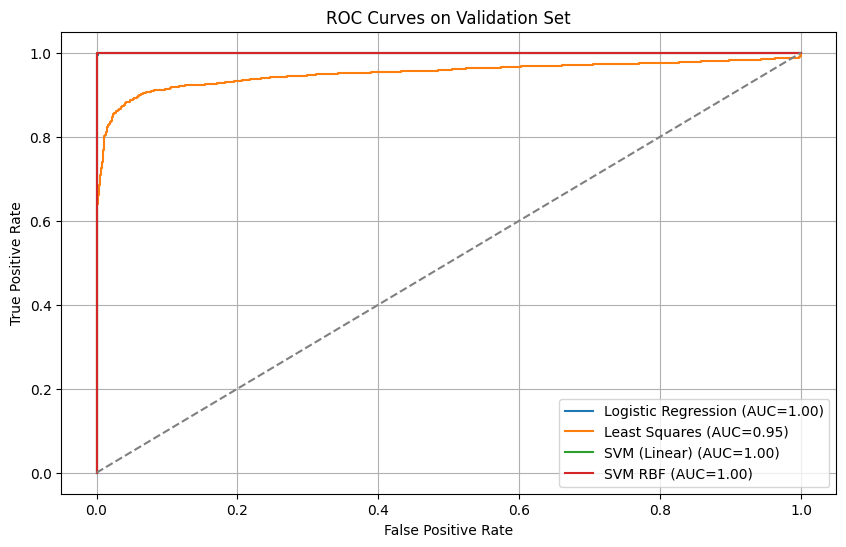

In [77]:
plt.figure(figsize=(10, 6))
for fpr, tpr, auc_val, label in results:
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_val:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves on Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


SVM (both linear and non-linear) and Logistic Regression has high AUC=1. 

In [86]:
# Pairing results with their corresponding model objects
models = [svm_linear.best_estimator_, logreg.best_estimator_, linreg, best_svm_rbf]
scored_models = []

for (fpr, tpr, auc_val, name), model in zip(results, models):
    scored_models.append((auc_val, name, model))

# Sorting by AUC descending
scored_models.sort(reverse=True, key=lambda x: round(x[0], 5))

# Getting top 2
top_models = scored_models[:3]

# Printing results
print("\n Top 3 Models on Validation Set (by AUC):")
for i, (auc_val, name, _) in enumerate(top_models, start=1):
    print(f"{i}. {name} (AUC = {auc_val:.5f})")


 Top 3 Models on Validation Set (by AUC):
1. SVM (Linear) (AUC = 1.00000)
2. SVM RBF (AUC = 0.99999)
3. Logistic Regression (AUC = 0.99998)


In [55]:
#Retrain best model on full training set (train + val)
print("Retraining best model on full train+val set...")
X_trainval = np.vstack([X_train_scaled, X_val_scaled])
y_trainval = np.hstack([y_train, y_val])

Retraining best model on full train+val set...


In [114]:
# Retraining top 3 models on combined train + validation set
final_models = []
total = len(top_models)

print(f"\n Retraining {total} top models on full train+val set...")

for i, (auc_val, name, model_obj) in enumerate(top_models, start=1):
    print(f"\n[{i}/{total}] Retraining '{name}' ...")
    start = time.time()

    # RecreatING model to avoid data leakage
    if name == "Least Squares":
        new_model = LinearRegression()
    elif name == "SVM (Linear)":
        new_model = LinearSVC(C=model_obj.get_params().get('C', 1.0), max_iter=10000)
    else:
        new_model = model_obj.__class__(**model_obj.get_params())

    new_model.fit(X_trainval, y_trainval)
    final_models.append((name, new_model))

    end = time.time()
    duration = end - start
    print(f" Retraining of '{name}' complete. Time taken: {duration:.2f} sec ({duration/60:.1f} min)")




 Retraining 3 top models on full train+val set...

[1/3] Retraining 'SVM (Linear)' ...
 Retraining of 'SVM (Linear)' complete. Time taken: 20.55 sec (0.3 min)

[2/3] Retraining 'SVM RBF' ...
 Retraining of 'SVM RBF' complete. Time taken: 207.93 sec (3.5 min)

[3/3] Retraining 'Logistic Regression' ...
 Retraining of 'Logistic Regression' complete. Time taken: 567.57 sec (9.5 min)


In [115]:
for name, _ in final_models:
    print(f" - {name}")

print(len(final_models))

 - SVM (Linear)
 - SVM RBF
 - Logistic Regression
3


In [ ]:
def evaluate_on_test_set(model_name, model, X_test_scaled, y_test):

    print(f"\nEvaluating Final Model ({model_name})...")

    is_regressor = (model_name == "Least Squares")

    # SVC → wrap for predict_proba
    if (model_name == "SVM (Linear)" or model_name == "SVM RBF") and not hasattr(model, "predict_proba"):
        print(" Wrapping LinearSVC with CalibratedClassifierCV for probability support...")
        model = CalibratedClassifierCV(model, method='sigmoid')
        model.fit(X_test_scaled, y_test)  # only for enabling predict_proba

    fpr, tpr, auc_val, _ = evaluate_model(
        f"Final Model ({model_name})",
        model,
        X_test_scaled,
        y_test,
        is_regressor=is_regressor
    )

    # Predict for confusion matrix
    y_pred = model.predict(X_test_scaled)
    if y_pred.ndim > 1 or not set(np.unique(y_pred)).issubset({0, 1}):
        y_pred = (y_pred >= 0.5).astype(int)

    print(f"\n Confusion Matrix for Final Model ({model_name}):")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "AI (1)"])
    disp.plot(cmap='Blues')
    print(cm)

    # ROC Curve
    print(f"\n ROC Curve for Final Model ({model_name})")
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Evaluating Final Model (SVM (Linear))...
 Wrapping LinearSVC with CalibratedClassifierCV for probability support...

📘 Final Model (SVM (Linear)) Performance
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      1500
AI-generated       1.00      1.00      1.00      1488

    accuracy                           1.00      2988
   macro avg       1.00      1.00      1.00      2988
weighted avg       1.00      1.00      1.00      2988


 Confusion Matrix for Final Model (SVM (Linear)):
[[1500    0]
 [   0 1488]]

 ROC Curve for Final Model (SVM (Linear))


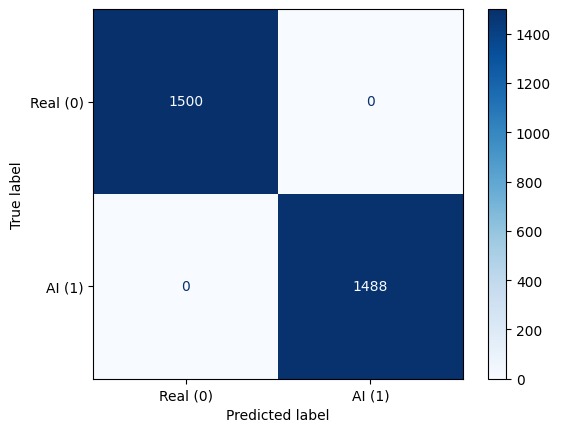

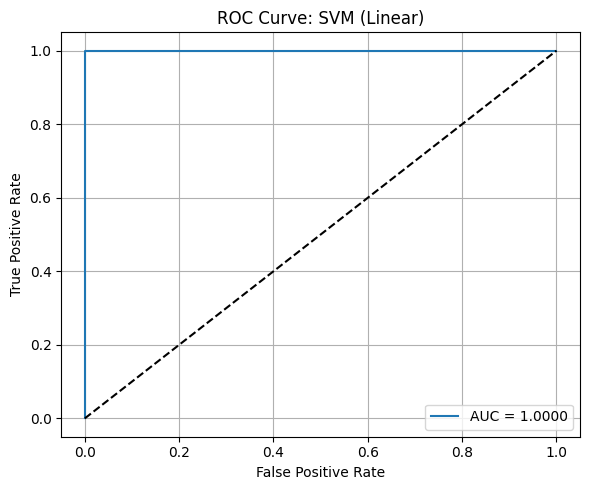


Evaluating Final Model (SVM RBF)...
 Wrapping LinearSVC with CalibratedClassifierCV for probability support...

📘 Final Model (SVM RBF) Performance
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      1500
AI-generated       1.00      1.00      1.00      1488

    accuracy                           1.00      2988
   macro avg       1.00      1.00      1.00      2988
weighted avg       1.00      1.00      1.00      2988


 Confusion Matrix for Final Model (SVM RBF):
[[1500    0]
 [   7 1481]]

 ROC Curve for Final Model (SVM RBF)


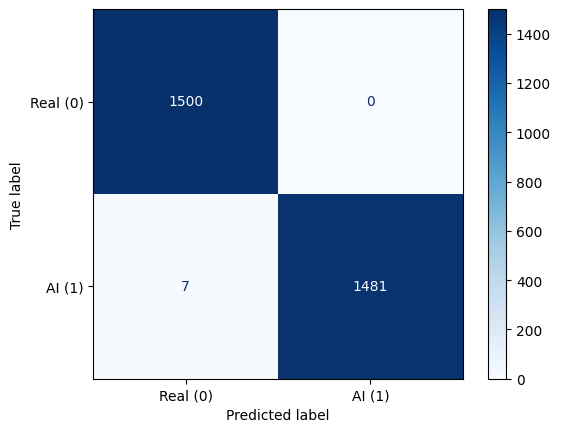

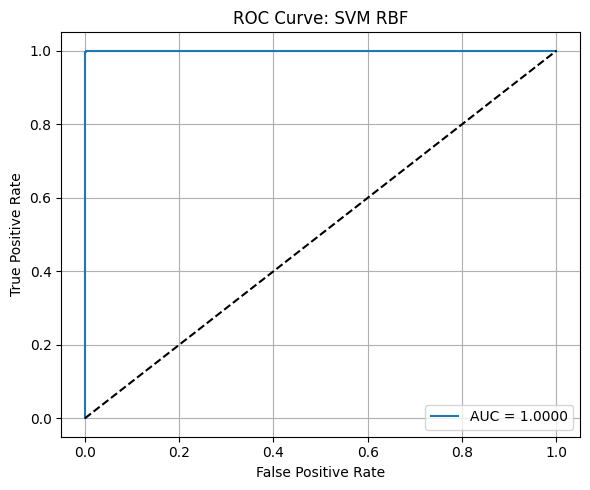


Evaluating Final Model (Logistic Regression)...

📘 Final Model (Logistic Regression) Performance
              precision    recall  f1-score   support

        Real       0.99      1.00      1.00      1500
AI-generated       1.00      0.99      1.00      1488

    accuracy                           1.00      2988
   macro avg       1.00      1.00      1.00      2988
weighted avg       1.00      1.00      1.00      2988


 Confusion Matrix for Final Model (Logistic Regression):
[[1500    0]
 [   9 1479]]

 ROC Curve for Final Model (Logistic Regression)


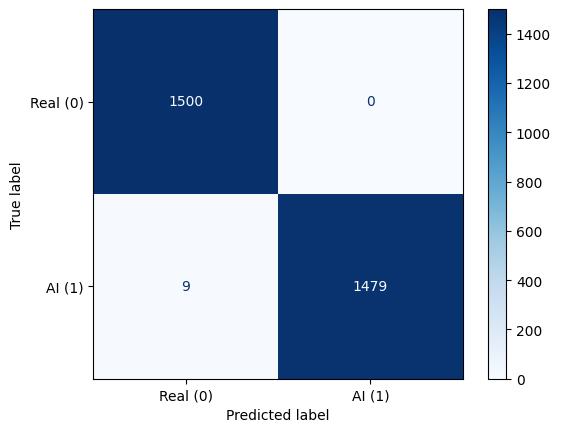

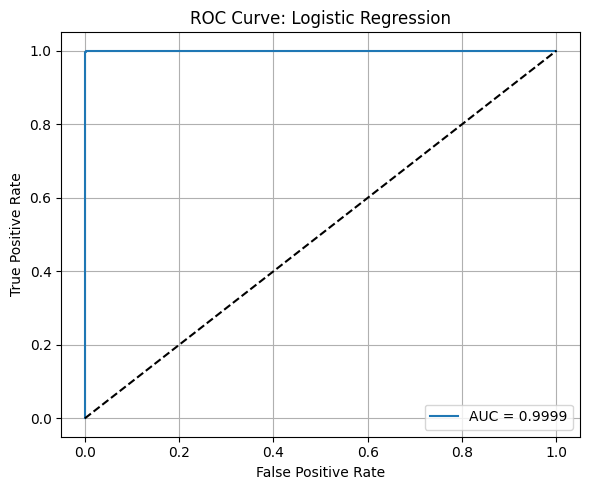

In [118]:
for name, model in final_models:
    evaluate_on_test_set(name, model, X_test_scaled, y_test)


### My reflections

For SVM, I had trouble running it on my local machine due to limited computational resources. I had to reduce the number of fits during hyperparameter tuning. Specifically, I had to choose between reducing the number of C values or reducing the number of cross-validation folds (cv).

Upon researching online, I found that retaining a higher number of cross-validation folds (e.g., 5-fold CV) generally provides more reliable performance estimates, especially on small datasets. Reducing the number of C values (e.g., testing only [0.1, 1]) has a smaller impact on model selection, while still allowing the cross-validation process to detect overfitting or underfitting effectively. Therefore, I chose to prioritize keeping 5-fold CV and reduced the size of the C parameter grid to minimize computation while maintaining evaluation robustness. But eventually I had to bring it down to 3, since 5 was still hard to train on my local.

My AUC is almost 1 for 3 models in train and train+val data, I suspect there might have been some overfitting somewhere in the process, possibly due to the models capturing noise or patterns specific to the training distribution. While high AUC indicates strong separability, such perfect scores rarely generalize in real-world scenarios.
I attempted to address this concern using cross-validation and hyperparameter tuning with regularization; however, the limitations of my computing hardware constrained the depth of exploration. Additionally, I suspect that the method of extracting frames from videos may have introduced bias or redundancy in the dataset. A more diverse and representative dataset could have improved generalization and reduced the risk of overfitting.
I believe the dataset makes it too easy for the classifier to identify real images, as I extracted 100 frames per video, which has likely led to significant overfitting. All the 3 models were able to almost memorize the real images because of this.

##### Possible fixes for overfitting
1. Use a more diverse dataset — extract or augment real images in varied ways.
2. Increase regularization in SVM by lowering the C value to allow wider margins.
3. Reduce the number of features to simplify the model and prevent overfitting.
4. Apply stronger cross-validation (e.g., cv=5 or cv=10) when tuning SVM.